In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# **Import the Modules**

In [ ]:
#Importing necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import re
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

!pip install torchinfo
from torchinfo import summary

from sklearn.metrics import accuracy_score, confusion_matrix, hamming_loss, f1_score, classification_report
from sklearn.model_selection import learning_curve

In [ ]:
#Loading Dataset
train = pd.read_csv('train.csv', header= 0)
test =  pd.read_csv('test.csv', header = 0)

train = train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test = test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

print(train.shape)
print(test.shape)

(7352, 563)
(2947, 563)


In [ ]:
y_train = train.iloc[:, 562:]
x_train = train.iloc[:, :-1]
y_test = test.iloc[:, 562:]
x_test = test.iloc[:, :-1]
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(7352, 562)
(2947, 562)
(7352, 1)
(2947, 1)


In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# For cross validation
x = np.concatenate([x_train, x_test], axis=0)
y = np.concatenate([y_train, y_test], axis=0)

# **Define visualization functions**

In [ ]:
def plot_learning_curve(estimator, X, y, ylim=None, cv=None, n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title('Learning Curve')
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.grid()
    if ylim is not None:
        plt.ylim(*ylim)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')
    plt.legend(loc='best')
    plt.show()

In [ ]:
def cm_heatmap(cm):
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
  plt.xlabel("Predicted Labels")
  plt.ylabel("True Labels")
  plt.title("Confusion Matrix Heatmap")
  plt.show()

In [ ]:
class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5']

def sixLabel_count_dataCleaning(y_pred):

  # Create one-hot encoded arrays for true and predicted labels
  y_test_onehot = np.zeros((len(y_test), len(class_labels)))
  y_test_onehot[np.arange(len(y_test)), y_test] = 1

  y_pred_onehot = np.zeros((len(y_test), len(class_labels)))
  y_pred_onehot[np.arange(len(y_test)), y_pred] = 1

  # Count the occurrences of each class in y_test and y_pred
  true_counts = np.sum(y_test_onehot, axis=0)
  pred_counts = np.sum(y_pred_onehot, axis=0)

  return true_counts, pred_counts

In [ ]:
def bar_chart(true_counts, pred_counts):
  bar_width = 0.35
  x = np.arange(len(class_labels))
  plt.bar(x, true_counts, width=bar_width, label='True Labels')
  plt.bar(x + bar_width, pred_counts, width=bar_width, label='Predicted Labels')
  plt.xlabel('Class Labels')
  plt.ylabel('Count')
  plt.title('True vs Predicted Labels')
  plt.xticks(x + bar_width / 2, class_labels)
  plt.legend()
  plt.show()

In [ ]:
def stacked_bar_chart(true_counts,pred_counts):
  x = np.arange(len(class_labels))
  plt.bar(x, true_counts, label='True Labels')
  plt.bar(x, pred_counts, bottom=true_counts, label='Predicted Labels')
  plt.xlabel('Class Labels')
  plt.ylabel('Count')
  plt.title('True vs Predicted Labels')
  plt.xticks(x, class_labels)
  plt.legend()
  plt.show()

# **Define DL Functions**

In [ ]:
def train(model, criterion, optimizer, epochs, dataloader, verbose=True):

  loss_history = []
  for epoch in range(epochs):
    for i, data in enumerate(dataloader, 0):

      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs.to(device), labels)
      loss.backward()
      optimizer.step()
      loss_history.append(loss.item())

    if verbose: print(f'Epoch {epoch} / {epochs}: avg. loss of last 5 iterations {np.sum(loss_history[:-6:-1])/5}')

  return loss_history

#################################################################
# Source: Middle East Technical University's CENG501 course
#################################################################

# **1 Softmax Regression (Multinomial Logistic Regression)**

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier_lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
classifier_lr.fit(x_train, y_train)

LogisticRegression(max_iter=10000, multi_class='multinomial')

In [ ]:
y_pred_lr = classifier_lr.predict(x_test)

In [ ]:
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print("Accuracy (LR):", accuracy_lr)

Accuracy (LR): 0.9596199524940617


In [ ]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
print("Confusion Matrix (LR):")
print(cm_lr)

Confusion Matrix (LR):
[[537   0   0   0   0   0]
 [  0 425  63   0   0   3]
 [  0  10 521   1   0   0]
 [  0   0   0 493   3   0]
 [  0   0   0   3 407  10]
 [  0   0   0  26   0 445]]


In [ ]:
report_lr = classification_report(y_test, y_pred_lr)
print("Classification Report (LR):")
print(report_lr)

Classification Report (LR):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.98      0.87      0.92       491
           2       0.89      0.98      0.93       532
           3       0.94      0.99      0.97       496
           4       0.99      0.97      0.98       420
           5       0.97      0.94      0.96       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



In [ ]:
hamming_loss_lr = hamming_loss(y_test, y_pred_lr)
print("Hamming Loss (LR):", hamming_loss_lr)

Hamming Loss (LR): 0.040380047505938245


In [ ]:
micro_f1_lr = f1_score(y_test, y_pred_lr, average='micro')
macro_f1_lr = f1_score(y_test, y_pred_lr, average='macro')

print("Micro-average F1-score (LR):", micro_f1_lr)
print("Macro-average F1-score (LR):", macro_f1_lr)

Micro-average F1-score (LR): 0.9596199524940617
Macro-average F1-score (LR): 0.9596626497521262


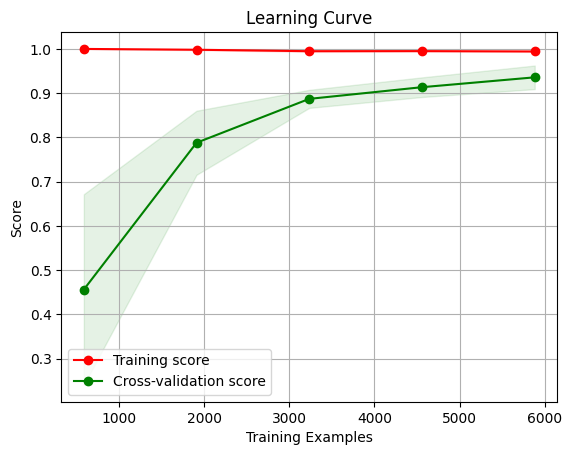

In [ ]:
plot_learning_curve(classifier_lr, x_train, y_train)

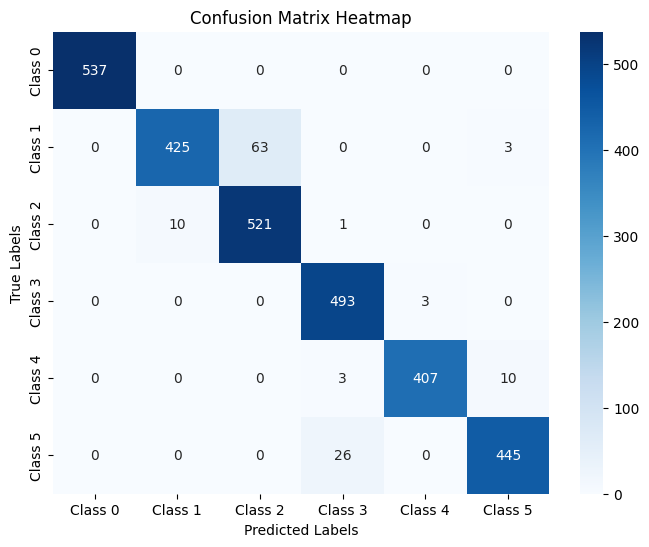

In [ ]:
cm_heatmap(cm_lr)

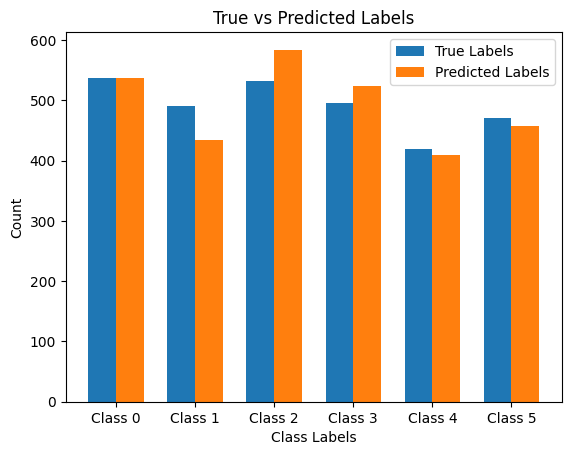

In [ ]:
true_counts_lr, pred_counts_lr = sixLabel_count_dataCleaning(y_pred_lr)
bar_chart(true_counts_lr, pred_counts_lr)

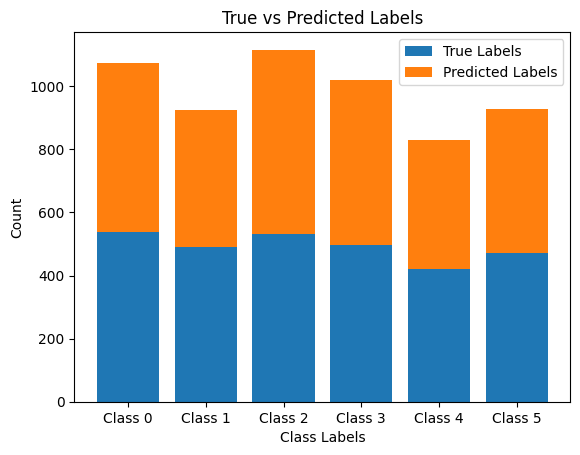

In [ ]:
stacked_bar_chart(true_counts_lr, pred_counts_lr)

# **2 One-vs-Rest Logistic Regression with Extensions**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import StandardScaler

# Scale the training and test data
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

classifier_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000))
classifier_ovr.fit(x_train_scaled, y_train)

OneVsRestClassifier(estimator=LogisticRegression(max_iter=1000))

In [ ]:
y_pred_ovr = classifier_ovr.predict(x_test_scaled)

In [ ]:
accuracy_ovr = accuracy_score(y_test, y_pred_ovr)
print("Accuracy (OVR):", accuracy_ovr)

Accuracy (OVR): 0.9589412962334578


In [ ]:
cm_ovr = confusion_matrix(y_test, y_pred_ovr)
print("Confusion Matrix (OVR):")
print(cm_ovr)

Confusion Matrix (OVR):
[[537   0   0   0   0   0]
 [  1 422  66   0   0   2]
 [  0  11 520   1   0   0]
 [  0   0   0 494   2   0]
 [  0   0   0   5 406   9]
 [  0   0   0  24   0 447]]


In [ ]:
report_ovr = classification_report(y_test, y_pred_ovr)
print("Classification Report (OVR):")
print(report_ovr)

Classification Report (OVR):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.97      0.86      0.91       491
           2       0.89      0.98      0.93       532
           3       0.94      1.00      0.97       496
           4       1.00      0.97      0.98       420
           5       0.98      0.95      0.96       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



In [ ]:
hamming_loss_ovr = hamming_loss(y_test, y_pred_ovr)
print("Hamming Loss (OVR):", hamming_loss_ovr)

Hamming Loss (OVR): 0.04105870376654225


In [ ]:
micro_f1_ovr = f1_score(y_test, y_pred_ovr, average='micro')
macro_f1_ovr = f1_score(y_test, y_pred_ovr, average='macro')

print("Micro-average F1-score (OVR):", micro_f1_ovr)
print("Macro-average F1-score (OVR):", macro_f1_ovr)

Micro-average F1-score (OVR): 0.9589412962334577
Macro-average F1-score (OVR): 0.9590585165360143


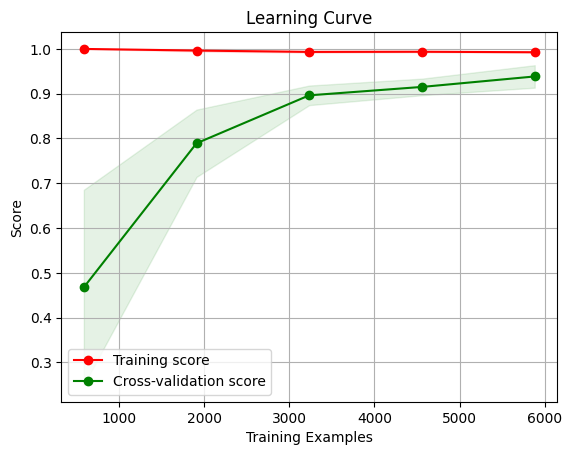

In [ ]:
plot_learning_curve(classifier_ovr, x_train, y_train)

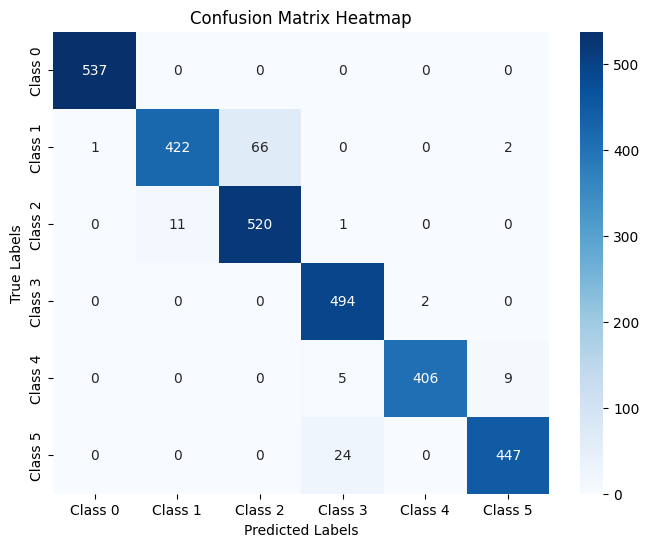

In [ ]:
cm_heatmap(cm_ovr)

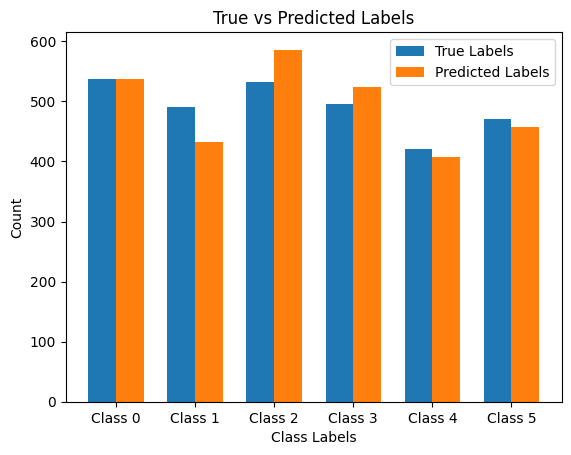

In [ ]:
true_counts_ovr, pred_counts_ovr = sixLabel_count_dataCleaning(y_pred_ovr)
bar_chart(true_counts_ovr, pred_counts_ovr)

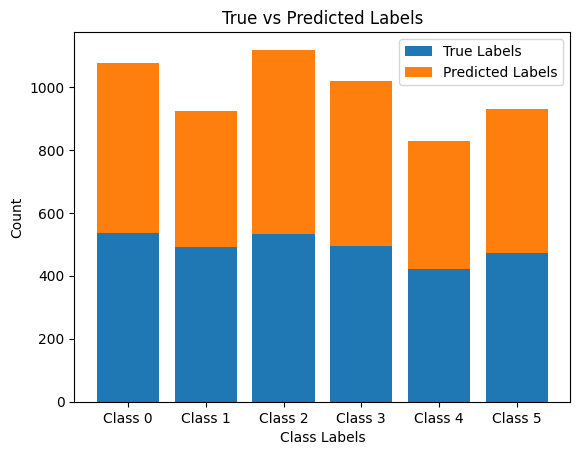

In [ ]:
stacked_bar_chart(true_counts_ovr, pred_counts_ovr)

# **3 K-Nearest Neighbor**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
classifier_knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier_knn.fit(x_train, y_train)

KNeighborsClassifier()

In [ ]:
y_pred_knn = classifier_knn.predict(x_test)

In [ ]:
accuracy_knn = accuracy_score(y_test, y_pred_knn)
print("Accuracy (K-NN):", accuracy_knn)

Accuracy (K-NN): 0.8096369189005769


In [ ]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
print("Confusion Matrix (K-NN):")
print(cm_knn)

Confusion Matrix (K-NN):
[[511  19   7   0   0   0]
 [  0 332 157   0   0   2]
 [  0  66 465   1   0   0]
 [  0   0   0 423  43  30]
 [  0   0   0  78 313  29]
 [  0   0   0 101  28 342]]


In [ ]:
report_ovr = classification_report(y_test, y_pred_ovr)
print("Classification Report (OVR):")
print(report_ovr)

Classification Report (OVR):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.97      0.86      0.91       491
           2       0.89      0.98      0.93       532
           3       0.94      1.00      0.97       496
           4       1.00      0.97      0.98       420
           5       0.98      0.95      0.96       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



In [ ]:
hamming_loss_knn = hamming_loss(y_test, y_pred_knn)
print("Hamming Loss (K-NN):", hamming_loss_knn)

Hamming Loss (K-NN): 0.19036308109942315


In [ ]:
micro_f1_knn = f1_score(y_test, y_pred_knn, average='micro')
macro_f1_knn = f1_score(y_test, y_pred_knn, average='macro')

print("Micro-average F1-score (DK-NNT):", micro_f1_knn)
print("Macro-average F1-score (K-NN):", macro_f1_knn)

Micro-average F1-score (DK-NNT): 0.8096369189005769
Macro-average F1-score (K-NN): 0.8064180573545295


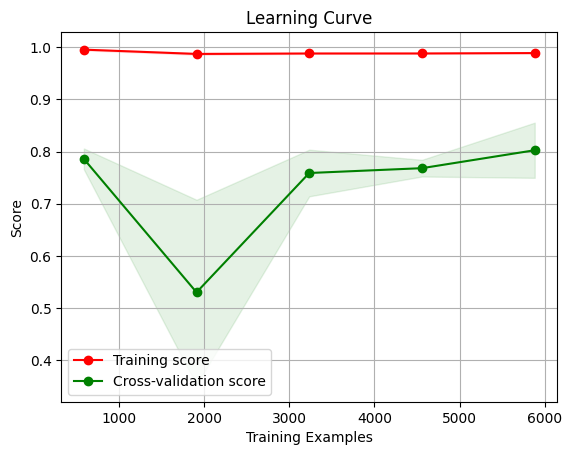

In [ ]:
plot_learning_curve(classifier_knn, x_train, y_train)

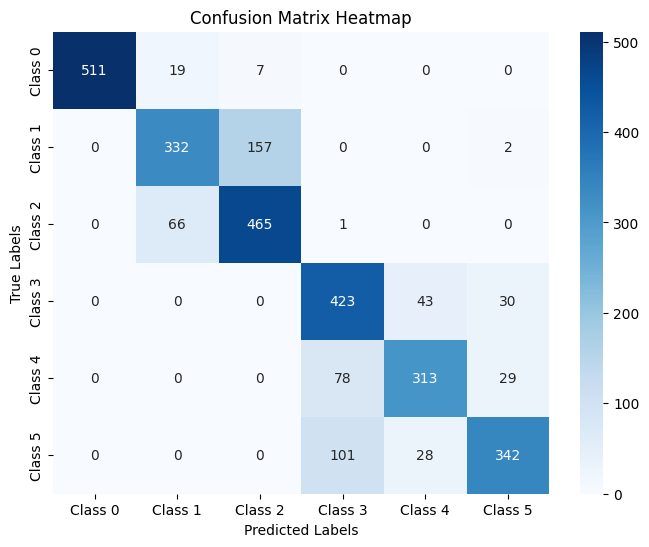

In [ ]:
cm_heatmap(cm_knn)

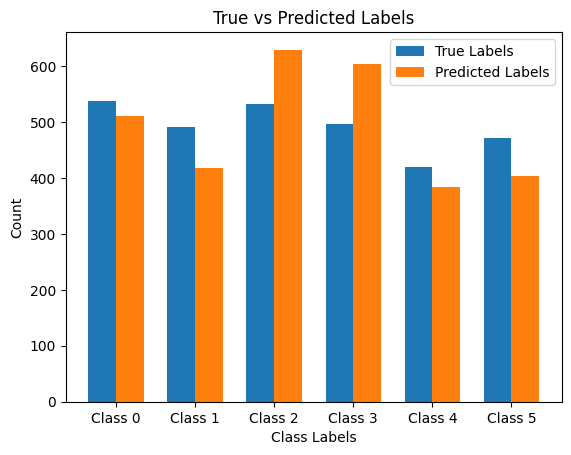

In [ ]:
true_counts_knn, pred_counts_knn = sixLabel_count_dataCleaning(y_pred_knn)
bar_chart(true_counts_knn, pred_counts_knn)

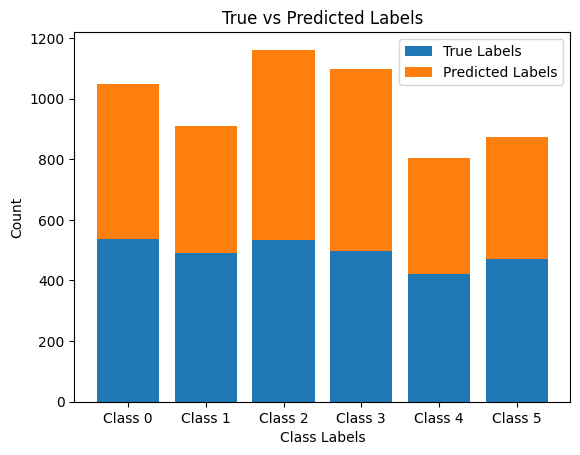

In [ ]:
stacked_bar_chart(true_counts_knn, pred_counts_knn)

# **4 Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
classifier_svm = SVC(kernel = 'linear', random_state = 0)
classifier_svm.fit(x_train, y_train)

SVC(kernel='linear', random_state=0)

In [ ]:
y_pred_svm = classifier_svm.predict(x_test)

In [ ]:
accuracy_svm = accuracy_score(y_test, y_pred_svm)
print("Accuracy (SVM):", accuracy_svm)

Accuracy (SVM): 0.9633525619273838


In [ ]:
cm_svm = confusion_matrix(y_test, y_pred_svm)
print("Confusion Matrix (SVM):")
print(cm_svm)

Confusion Matrix (SVM):
[[537   0   0   0   0   0]
 [  0 435  55   0   0   1]
 [  0  16 516   0   0   0]
 [  0   0   0 494   1   1]
 [  0   0   0   4 410   6]
 [  0   0   0  22   2 447]]


In [ ]:
report_svm = classification_report(y_test, y_pred_svm)
print("Classification Report (SVM):")
print(report_svm)

Classification Report (SVM):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.96      0.89      0.92       491
           2       0.90      0.97      0.94       532
           3       0.95      1.00      0.97       496
           4       0.99      0.98      0.98       420
           5       0.98      0.95      0.97       471

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



In [ ]:
hamming_loss_svm = hamming_loss(y_test, y_pred_svm)
print("Hamming Loss (SVM):", hamming_loss_svm)

Hamming Loss (SVM): 0.03664743807261622


In [ ]:
micro_f1_svm = f1_score(y_test, y_pred_svm, average='micro')
macro_f1_svm = f1_score(y_test, y_pred_svm, average='macro')

print("Micro-average F1-score (SVM):", micro_f1_svm)
print("Macro-average F1-score (SVM):", macro_f1_svm)

Micro-average F1-score (SVM): 0.9633525619273838
Macro-average F1-score (SVM): 0.9635790742787718


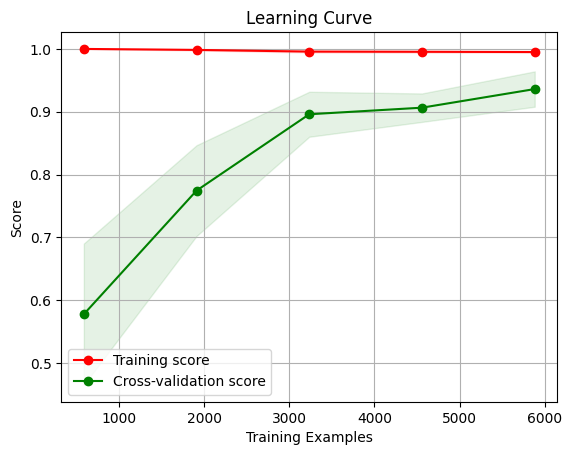

In [ ]:
plot_learning_curve(classifier_svm, x_train, y_train)

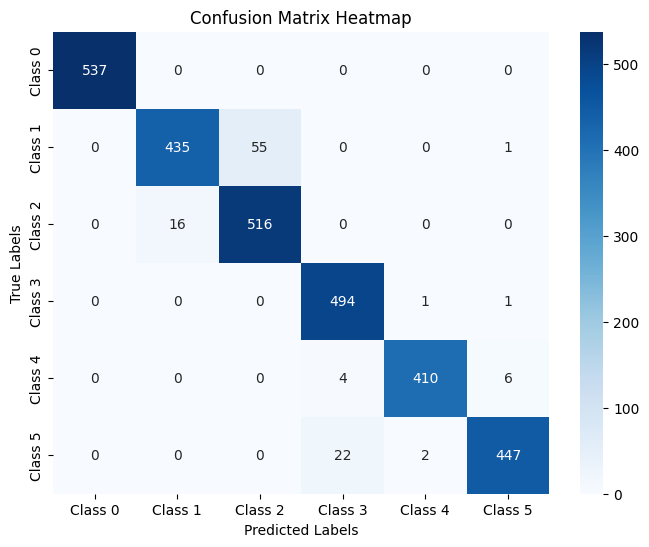

In [ ]:
cm_heatmap(cm_svm)

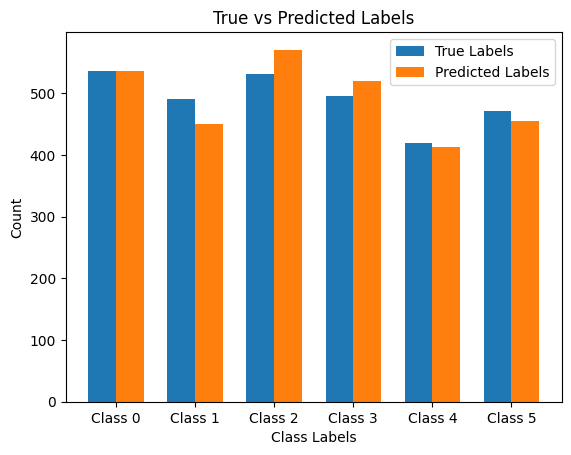

In [ ]:
true_counts_svm, pred_counts_svm = sixLabel_count_dataCleaning(y_pred_svm)
bar_chart(true_counts_svm, pred_counts_svm)

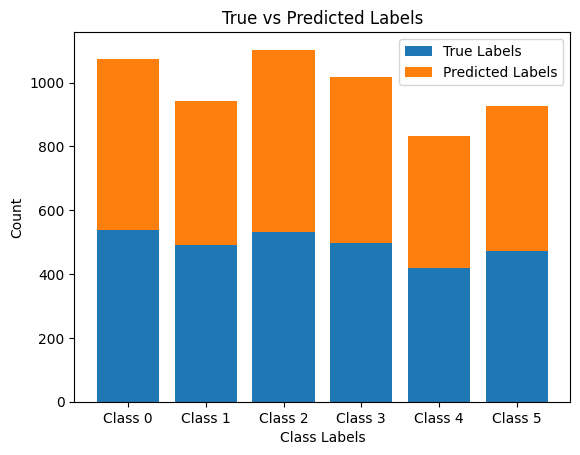

In [ ]:
stacked_bar_chart(true_counts_svm, pred_counts_svm)

# **5 Kernal**

In [ ]:
from sklearn.svm import SVC
classifier_kernal = SVC(kernel = 'rbf', random_state = 0)
classifier_kernal.fit(x_train, y_train)

SVC(random_state=0)

In [ ]:
y_pred_kernal = classifier_kernal.predict(x_test)

In [ ]:
accuracy_kernal = accuracy_score(y_test, y_pred_kernal)
print("Accuracy (Kernal):", accuracy_kernal)

Accuracy (Kernal): 0.9307770614183916


In [ ]:
cm_kernal = confusion_matrix(y_test, y_pred_kernal)
print("Confusion Matrix (Kernal):")
print(cm_kernal)

Confusion Matrix (Kernal):
[[537   0   0   0   0   0]
 [  0 421  68   0   0   2]
 [  0  45 487   0   0   0]
 [  0   0   0 494   2   0]
 [  0   0   0  33 358  29]
 [  0   0   0  23   2 446]]


In [ ]:
report_kernal = classification_report(y_test, y_pred_kernal)
print("Classification Report (Kernal):")
print(report_kernal)

Classification Report (Kernal):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.90      0.86      0.88       491
           2       0.88      0.92      0.90       532
           3       0.90      1.00      0.94       496
           4       0.99      0.85      0.92       420
           5       0.94      0.95      0.94       471

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



In [ ]:
hamming_loss_kernal = hamming_loss(y_test, y_pred_kernal)
print("Hamming Loss (Kernal):", hamming_loss_kernal)

Hamming Loss (Kernal): 0.06922293858160841


In [ ]:
micro_f1_kernal = f1_score(y_test, y_pred_kernal, average='micro')
macro_f1_kernal = f1_score(y_test, y_pred_kernal, average='macro')

print("Micro-average F1-score (Kernal):", micro_f1_kernal)
print("Macro-average F1-score (Kernal):", macro_f1_kernal)

Micro-average F1-score (Kernal): 0.9307770614183916
Macro-average F1-score (Kernal): 0.9294928218961872


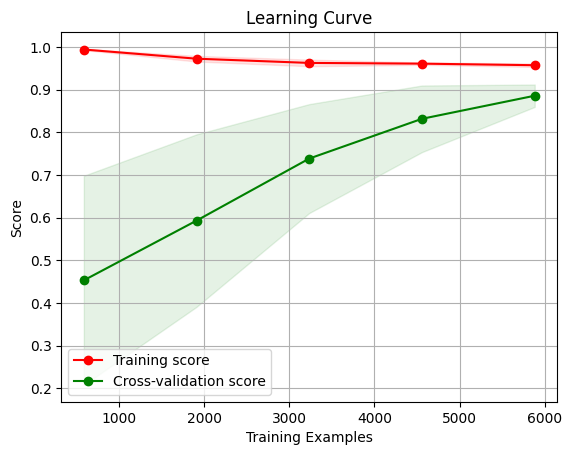

In [ ]:
plot_learning_curve(classifier_kernal, x_train, y_train)

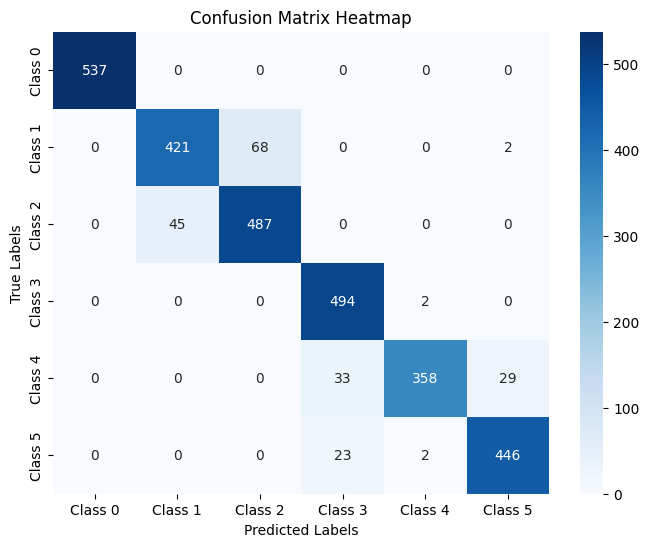

In [ ]:
cm_heatmap(cm_kernal)

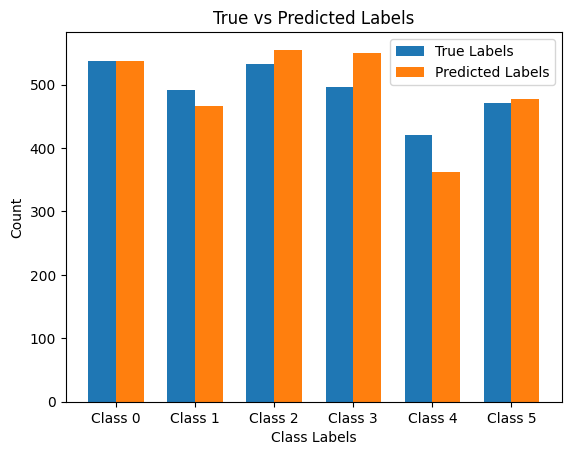

In [ ]:
true_counts_kernal, pred_counts_kernal = sixLabel_count_dataCleaning(y_pred_kernal)
bar_chart(true_counts_kernal, pred_counts_kernal)

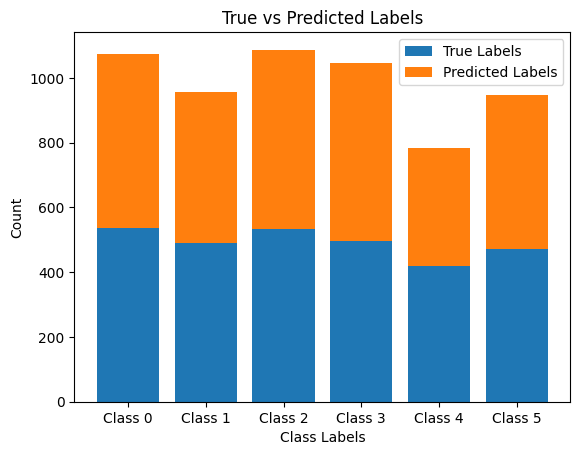

In [ ]:
stacked_bar_chart(true_counts_kernal, pred_counts_kernal)

# **6 Naive Bayes**

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

classifier_nb = MultinomialNB()
classifier_nb.fit(x_train_scaled, y_train)

MultinomialNB()

In [ ]:
y_pred_nb = classifier_nb.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but MultinomialNB was fitted without feature names
  warnings.warn(


In [ ]:
accuracy_nb = accuracy_score(y_test, y_pred_nb)
print("Accuracy (NB):", accuracy_nb)

Accuracy (NB): 0.166949440108585


In [ ]:
cm_nb = confusion_matrix(y_test, y_pred_nb)
print("Confusion Matrix (NB):")
print(cm_nb)

Confusion Matrix (NB):
[[  0 537   0   0   0   0]
 [  0 491   0   0   0   0]
 [  0 531   1   0   0   0]
 [  0   4 492   0   0   0]
 [  0  15 405   0   0   0]
 [  0 119 352   0   0   0]]


In [ ]:
report_nb = classification_report(y_test, y_pred_nb)
print("Classification Report (NB):")
print(report_nb)

Classification Report (NB):
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       537
           1       0.29      1.00      0.45       491
           2       0.00      0.00      0.00       532
           3       0.00      0.00      0.00       496
           4       0.00      0.00      0.00       420
           5       0.00      0.00      0.00       471

    accuracy                           0.17      2947
   macro avg       0.05      0.17      0.07      2947
weighted avg       0.05      0.17      0.07      2947



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
hamming_loss_nb = hamming_loss(y_test, y_pred_nb)
print("Hamming Loss (NB):", hamming_loss_nb)

Hamming Loss (NB): 0.833050559891415


In [ ]:
micro_f1_nb = f1_score(y_test, y_pred_nb, average='micro')
macro_f1_nb = f1_score(y_test, y_pred_nb, average='macro')

print("Micro-average F1-score (NB):", micro_f1_nb)
print("Macro-average F1-score (NB):", macro_f1_nb)

Micro-average F1-score (NB): 0.166949440108585
Macro-average F1-score (NB): 0.07498900577308053


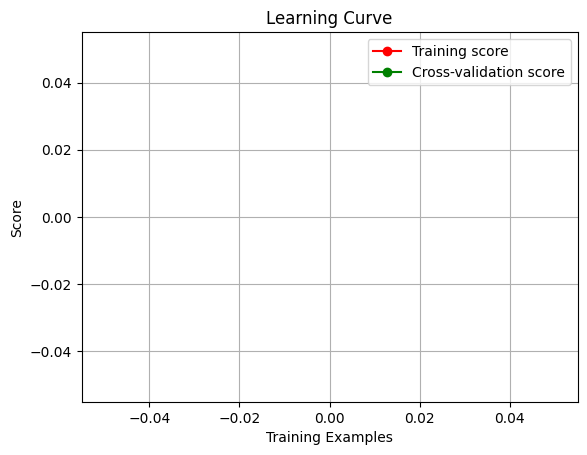

In [ ]:
plot_learning_curve(classifier_nb, x_train, y_train)

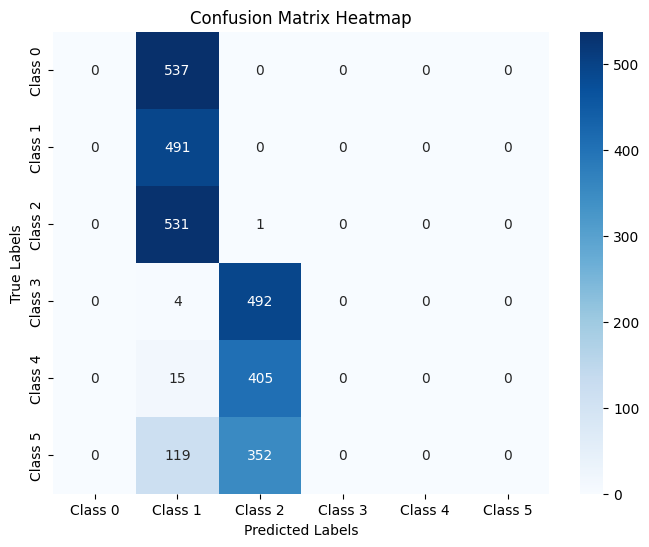

In [ ]:
cm_heatmap(cm_nb)

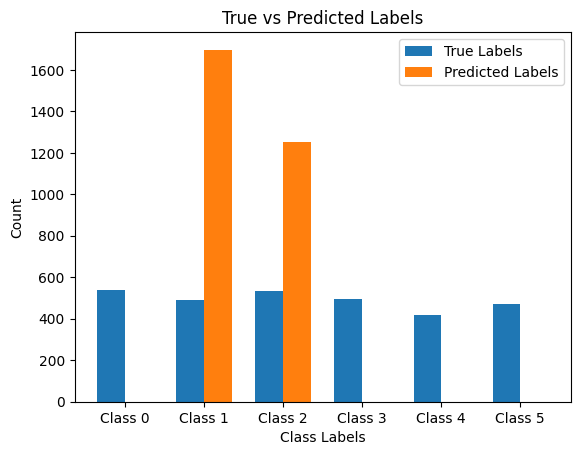

In [ ]:
true_counts_nb, pred_counts_nb = sixLabel_count_dataCleaning(y_pred_nb)
bar_chart(true_counts_nb, pred_counts_nb)

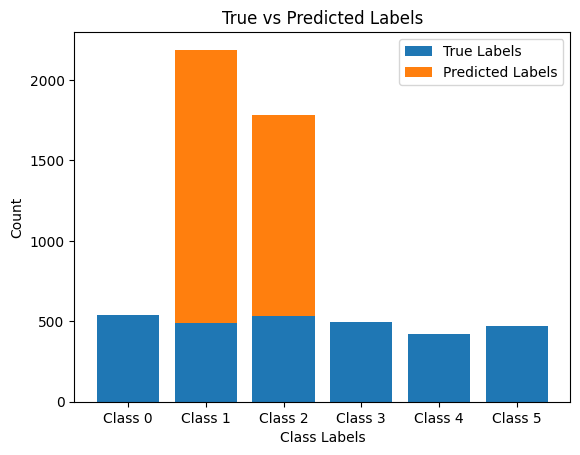

In [ ]:
stacked_bar_chart(true_counts_nb, pred_counts_nb)

# **7 Decision Tree**

In [ ]:
from sklearn.tree import DecisionTreeClassifier
classifier_dt = DecisionTreeClassifier(criterion = 'gini', random_state = 0)
classifier_dt.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

In [ ]:
y_pred_dt = classifier_dt.predict(x_test)

In [ ]:
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("Accuracy (DT):", accuracy_dt)

Accuracy (DT): 0.8639294197488971


In [ ]:
cm_dt = confusion_matrix(y_test, y_pred_dt)
print("Confusion Matrix (DT):")
print(cm_dt)

Confusion Matrix (DT):
[[537   0   0   0   0   0]
 [  0 387 104   0   0   0]
 [  0  85 447   0   0   0]
 [  0   0   0 453  20  23]
 [  0   0   0  15 352  53]
 [  0   0   0  63  38 370]]


In [ ]:
report_dt = classification_report(y_test, y_pred_dt)
print("Classification Report (DT):")
print(report_dt)

Classification Report (DT):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.82      0.79      0.80       491
           2       0.81      0.84      0.83       532
           3       0.85      0.91      0.88       496
           4       0.86      0.84      0.85       420
           5       0.83      0.79      0.81       471

    accuracy                           0.86      2947
   macro avg       0.86      0.86      0.86      2947
weighted avg       0.86      0.86      0.86      2947



In [ ]:
hamming_loss_dt = hamming_loss(y_test, y_pred_dt)
print("Hamming Loss (DT):", hamming_loss_dt)

Hamming Loss (DT): 0.13607058025110283


In [ ]:
micro_f1_dt = f1_score(y_test, y_pred_dt, average='micro')
macro_f1_dt = f1_score(y_test, y_pred_dt, average='macro')

print("Micro-average F1-score (DT):", micro_f1_dt)
print("Macro-average F1-score (DT):", macro_f1_dt)

Micro-average F1-score (DT): 0.8639294197488971
Macro-average F1-score (DT): 0.8610960406125362


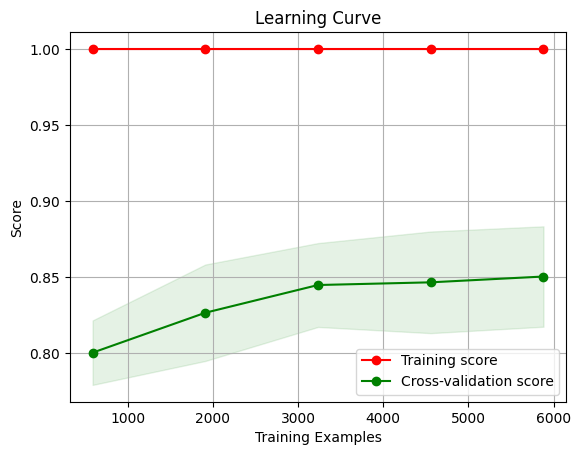

In [ ]:
plot_learning_curve(classifier_dt, x_train, y_train)

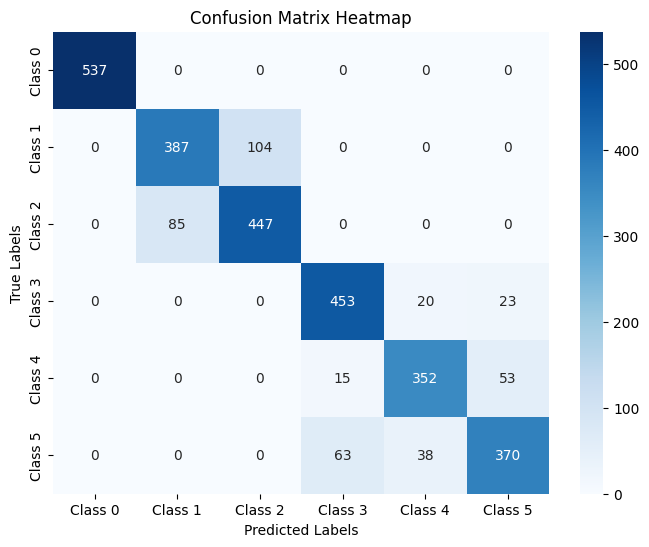

In [ ]:
cm_heatmap(cm_dt)

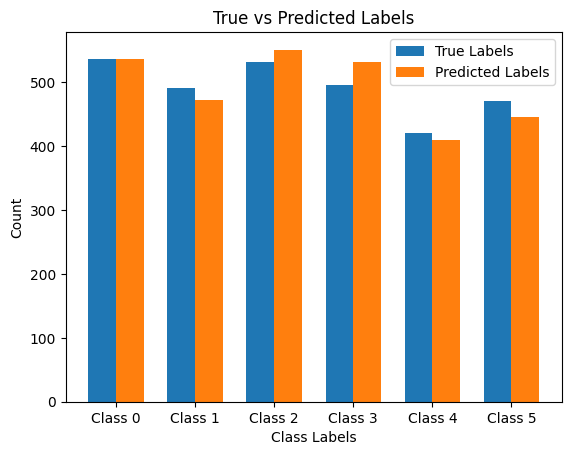

In [ ]:
true_counts_dt, pred_counts_dt = sixLabel_count_dataCleaning(y_pred_dt)
bar_chart(true_counts_dt, pred_counts_dt)

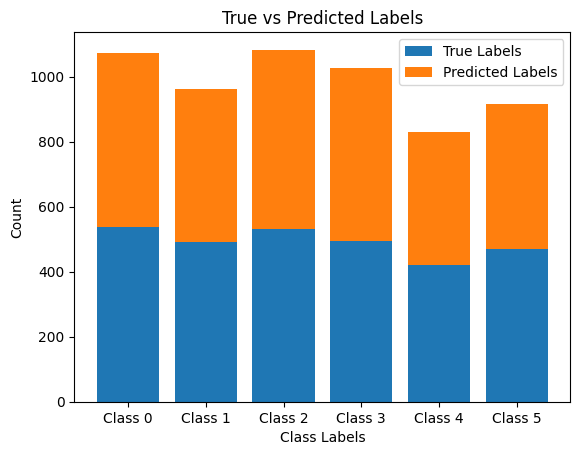

In [ ]:
stacked_bar_chart(true_counts_dt, pred_counts_dt)

# **8 Random Forest**

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier_rf = RandomForestClassifier(criterion='log_loss', n_jobs=-1, random_state=42)
classifier_rf.fit(x_train, y_train)

RandomForestClassifier(criterion='log_loss', n_jobs=-1, random_state=42)

In [ ]:
y_pred_rf = classifier_rf.predict(x_test)

In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy (RF):", accuracy_rf)

Accuracy (RF): 0.9250084832032576


**Hyperparameter Tuning**

In [ ]:
# Tuning for min_weight_fraction_leaf

best_acc_rf = 0
best_min_weight_fraction_leaf = 0
best_min_weight_fraction_leaf_list = []


for i in range(1, 1000):
    classifier_rf = RandomForestClassifier(n_estimators = 50
                                           , criterion = 'log_loss'
                                           , random_state = 42
                                           , max_depth = 36
                                           , max_features = "log2"
                                           , n_jobs = -1
                                           , min_weight_fraction_leaf = i/1000000)
    classifier_rf.fit(x_train, y_train)
    y_pred_rf = classifier_rf.predict(x_test)
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    print("with min_weight_fraction_leaf of", i/1000000, "the Accuracy is:", accuracy_rf)

    if accuracy_rf > best_acc_rf:
        best_min_weight_fraction_leaf_list = []
        best_min_weight_fraction_leaf = i/1000000
        best_acc_rf = accuracy_rf

    elif accuracy_rf == best_acc_rf:
        best_min_weight_fraction_leaf_list.append(best_min_weight_fraction_leaf)


print("The best model has Accuracy", best_acc_rf, "when min_weight_fraction_leaf is", best_min_weight_fraction_leaf)

with min_weight_fraction_leaf of 1e-06 the Accuracy is: 0.9355276552426196
with min_weight_fraction_leaf of 2e-06 the Accuracy is: 0.9355276552426196
with min_weight_fraction_leaf of 3e-06 the Accuracy is: 0.9355276552426196
with min_weight_fraction_leaf of 4e-06 the Accuracy is: 0.9355276552426196
with min_weight_fraction_leaf of 5e-06 the Accuracy is: 0.9355276552426196
with min_weight_fraction_leaf of 6e-06 the Accuracy is: 0.9355276552426196
with min_weight_fraction_leaf of 7e-06 the Accuracy is: 0.9355276552426196
with min_weight_fraction_leaf of 8e-06 the Accuracy is: 0.9355276552426196
with min_weight_fraction_leaf of 9e-06 the Accuracy is: 0.9355276552426196
with min_weight_fraction_leaf of 1e-05 the Accuracy is: 0.9355276552426196
with min_weight_fraction_leaf of 1.1e-05 the Accuracy is: 0.9355276552426196
with min_weight_fraction_leaf of 1.2e-05 the Accuracy is: 0.9355276552426196
with min_weight_fraction_leaf of 1.3e-05 the Accuracy is: 0.9355276552426196
with min_weight_fra

In [ ]:
# Tuning for n_estimators & max_depth

best_acc_rf = 0
best_n_estimators = 0
best_n_estimators_list = []
best_max_depth = 0
best_max_depth_list = []

for j in range(1, 300, 10):
  for k in range(16, 37, 2):

        classifier_rf = RandomForestClassifier(n_estimators = j
                                               , criterion = 'log_loss'
                                               , random_state = 42
                                               , max_depth = k
                                               , max_features = "log2"
                                               , n_jobs = -1
                                               , min_weight_fraction_leaf = best_min_weight_fraction_leaf
                                               )
        classifier_rf.fit(x_train, y_train)
        y_pred_rf = classifier_rf.predict(x_test)
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        print("with n_estimators =", j,"and max_depth =", k, ",  the Accuracy is", accuracy_rf)

        if accuracy_rf > best_acc_rf:
            best_n_estimators_list = []
            best_n_estimators = j
            best_max_depth_list = []
            best_max_depth = k
            best_acc_rf = accuracy_rf

        elif accuracy_rf == best_acc_rf:
            best_n_estimators_list.append(best_n_estimators)
            best_max_depth_list.append(best_max_depth)


print("The best model has Accuracy", best_acc_rf, "when n_estimators =", best_n_estimators
      , "and max_depth =", best_max_depth)

with n_estimators = 1 and max_depth = 16 ,  the Accuracy is 0.8045469969460468
with n_estimators = 1 and max_depth = 18 ,  the Accuracy is 0.8025110281642348
with n_estimators = 1 and max_depth = 20 ,  the Accuracy is 0.8143875127248049
with n_estimators = 1 and max_depth = 22 ,  the Accuracy is 0.8143875127248049
with n_estimators = 1 and max_depth = 24 ,  the Accuracy is 0.8143875127248049
with n_estimators = 1 and max_depth = 26 ,  the Accuracy is 0.8143875127248049
with n_estimators = 1 and max_depth = 28 ,  the Accuracy is 0.8143875127248049
with n_estimators = 1 and max_depth = 30 ,  the Accuracy is 0.8143875127248049
with n_estimators = 1 and max_depth = 32 ,  the Accuracy is 0.8143875127248049
with n_estimators = 1 and max_depth = 34 ,  the Accuracy is 0.8143875127248049
with n_estimators = 1 and max_depth = 36 ,  the Accuracy is 0.8143875127248049
with n_estimators = 11 and max_depth = 16 ,  the Accuracy is 0.9168646080760094
with n_estimators = 11 and max_depth = 18 ,  the Ac

In [ ]:
# Tuning for min_samples_split & min_samples_leaf

best_acc_rf = 0
best_min_samples_split = 0
best_min_samples_split_list = []
best_min_samples_leaf = 0
best_min_samples_leaf_list = []

for m in range(1, 1000, 30):
  for n in range(1, 90, 2):

        classifier_rf = RandomForestClassifier(n_estimators = best_n_estimators
                                               , criterion = 'log_loss'
                                               , random_state = 42
                                               , max_depth = best_max_depth
                                               , max_features = "log2"
                                               , n_jobs = -1
                                               , min_weight_fraction_leaf = best_min_weight_fraction_leaf
                                               , min_samples_split = m/100000
                                               , min_samples_leaf = n
                                               )
        classifier_rf.fit(x_train, y_train)
        y_pred_rf = classifier_rf.predict(x_test)
        accuracy_rf = accuracy_score(y_test, y_pred_rf)
        print("with min_samples_split =", m/100000,"and min_samples_leaf =", n, ",  the Accuracy is", accuracy_rf)

        if accuracy_rf > best_acc_rf:
            best_min_samples_split_list = []
            best_min_samples_split = m/100000
            best_min_samples_leaf_list = []
            best_min_samples_leaf = n
            best_acc_rf = accuracy_rf

        elif accuracy_rf == best_acc_rf:
            best_min_samples_split_list.append(best_min_samples_split)
            best_min_samples_leaf_list.append(best_min_samples_leaf)


print("The best model has Accuracy", best_acc_rf, "when min_samples_split =", best_min_samples_split
      , "and min_samples_leaf =", best_min_samples_leaf)

with min_samples_split = 1e-05 and min_samples_leaf = 1 ,  the Accuracy is 0.9409569053274517
with min_samples_split = 1e-05 and min_samples_leaf = 3 ,  the Accuracy is 0.9338310145911096
with min_samples_split = 1e-05 and min_samples_leaf = 5 ,  the Accuracy is 0.9317950458092976
with min_samples_split = 1e-05 and min_samples_leaf = 7 ,  the Accuracy is 0.9348489989820156
with min_samples_split = 1e-05 and min_samples_leaf = 9 ,  the Accuracy is 0.9334916864608076
with min_samples_split = 1e-05 and min_samples_leaf = 11 ,  the Accuracy is 0.9284017645062775
with min_samples_split = 1e-05 and min_samples_leaf = 13 ,  the Accuracy is 0.9277231082456736
with min_samples_split = 1e-05 and min_samples_leaf = 15 ,  the Accuracy is 0.9250084832032576
with min_samples_split = 1e-05 and min_samples_leaf = 17 ,  the Accuracy is 0.9239904988123515
with min_samples_split = 1e-05 and min_samples_leaf = 19 ,  the Accuracy is 0.9222938581608415
with min_samples_split = 1e-05 and min_samples_leaf = 2

In [ ]:
classifier_rf = RandomForestClassifier(n_estimators = best_n_estimators
                                               , criterion = 'log_loss'
                                               , random_state = 42
                                               , max_depth = best_max_depth
                                               , max_features = "log2"
                                               , n_jobs = -1
                                               , min_weight_fraction_leaf = best_min_weight_fraction_leaf
                                               , min_samples_split = best_min_samples_split
                                               , min_samples_leaf = best_min_samples_leaf
                                               )
classifier_rf.fit(x_train, y_train)

RandomForestClassifier(criterion='log_loss', max_depth=22, max_features='log2',
                       min_samples_split=1e-05,
                       min_weight_fraction_leaf=0.000409, n_estimators=81,
                       n_jobs=-1, random_state=42)

In [ ]:
y_pred_rf = classifier_rf.predict(x_test)

In [ ]:
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("Accuracy (RF):", accuracy_rf)

Accuracy (RF): 0.9409569053274517


In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
print("Confusion Matrix (RF):")
print(cm_rf)

Confusion Matrix (RF):
[[537   0   0   0   0   0]
 [  1 435  55   0   0   0]
 [  0  10 521   0   0   1]
 [  0   0   0 489   4   3]
 [  0   0   0  25 351  44]
 [  0   0   0  24   7 440]]


In [ ]:
report_rf = classification_report(y_test, y_pred_rf)
print("Classification Report (RF):")
print(report_rf)

Classification Report (RF):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.98      0.89      0.93       491
           2       0.90      0.98      0.94       532
           3       0.91      0.99      0.95       496
           4       0.97      0.84      0.90       420
           5       0.90      0.93      0.92       471

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



In [ ]:
hamming_loss_rf = hamming_loss(y_test, y_pred_rf)
print("Hamming Loss (RF):", hamming_loss_rf)

Hamming Loss (RF): 0.059043094672548355


In [ ]:
micro_f1_rf = f1_score(y_test, y_pred_rf, average='micro')
macro_f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print("Micro-average F1-score (RF):", micro_f1_rf)
print("Macro-average F1-score (RF):", macro_f1_rf)

Micro-average F1-score (RF): 0.9409569053274517
Macro-average F1-score (RF): 0.9383587142926572


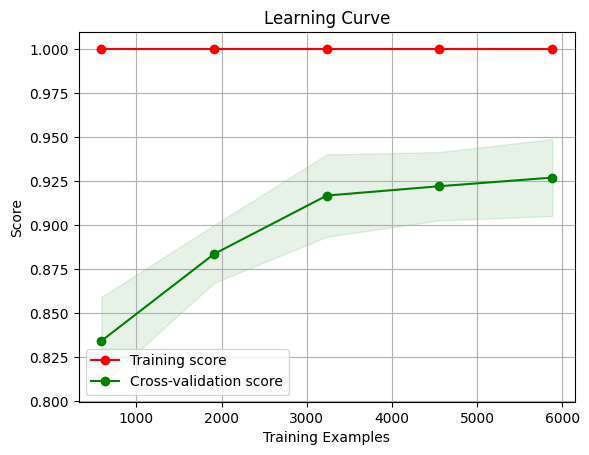

In [ ]:
plot_learning_curve(classifier_rf, x_train, y_train)

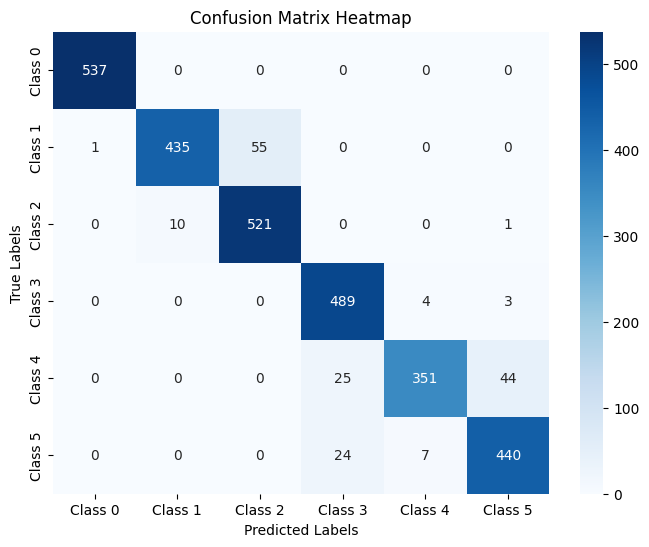

In [ ]:
cm_heatmap(cm_rf)

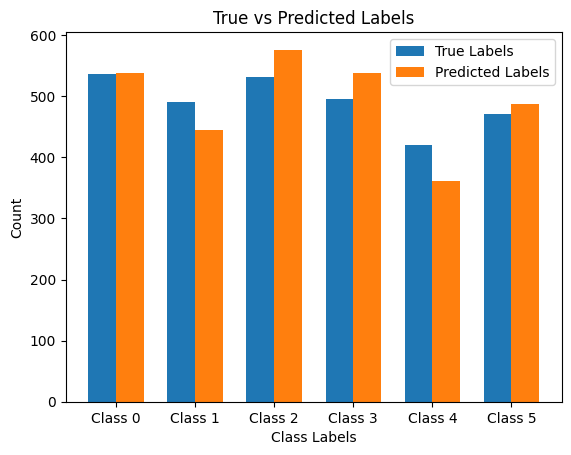

In [ ]:
true_counts_rf, pred_counts_rf = sixLabel_count_dataCleaning(y_pred_rf)
bar_chart(true_counts_rf, pred_counts_rf)

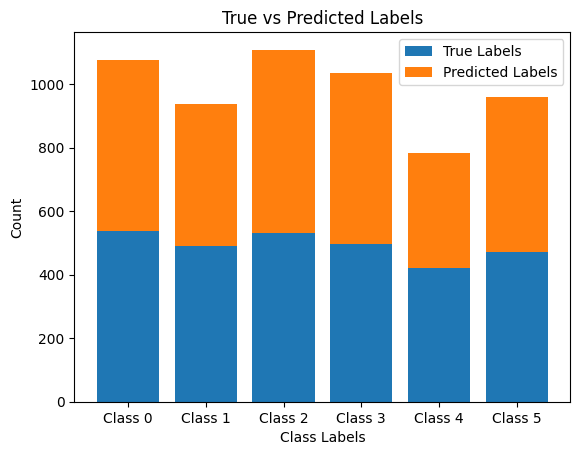

In [ ]:
stacked_bar_chart(true_counts_rf, pred_counts_rf)

# **9 XGBoost Classifier**

In [ ]:
import xgboost as xgb
classifier_xgb = xgb.XGBClassifier(base_score=2, booster=None, callbacks=None
                                   , random_state=42, colsample_bylevel=None
                                   , colsample_bynode=None, colsample_bytree=None
                                   , early_stopping_rounds=None, enable_categorical=False
                                   , eval_metric=None, feature_types=None, gamma=None
                                   , gpu_id=None, grow_policy=None, importance_type=None
                                   , interaction_constraints=None, learning_rate=None
                                   , max_bin=None, max_cat_threshold=None
                                   , max_cat_to_onehot=None, max_delta_step=None
                                   , max_depth=None, max_leaves=None, min_child_weight=10
                                   , monotone_constraints=None, n_estimators=200
                                   , n_jobs=-1, num_parallel_tree=10
                                   , objective='multi:softprob', predictor=None)
classifier_xgb.fit(x_train, y_train)

XGBClassifier(base_score=2, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=-1, num_parallel_tree=10,
              objective='multi:softprob', predictor=None, ...)

In [ ]:
y_pred_xgb = classifier_xgb.predict(x_test)

In [ ]:
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("Accuracy (XGB):", accuracy_xgb)

Accuracy (XGB): 0.9379029521547336


In [ ]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
print("Confusion Matrix (XGB):")
print(cm_xgb)

Confusion Matrix (XGB):
[[537   0   0   0   0   0]
 [  0 411  77   0   0   3]
 [  0  34 498   0   0   0]
 [  0   0   0 486   5   5]
 [  0   0   0   9 385  26]
 [  0   0   0  30   5 436]]


In [ ]:
report_xgb = classification_report(y_test, y_pred_xgb)
print("Classification Report (XGB):")
print(report_xgb)

Classification Report (XGB):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.92      0.84      0.88       491
           2       0.87      0.94      0.90       532
           3       0.93      0.98      0.95       496
           4       0.97      0.92      0.94       420
           5       0.93      0.93      0.93       471

    accuracy                           0.93      2947
   macro avg       0.94      0.93      0.93      2947
weighted avg       0.94      0.93      0.93      2947



In [ ]:
hamming_loss_xgb = hamming_loss(y_test, y_pred_xgb)
print("Hamming Loss (XGB):", hamming_loss_xgb)

Hamming Loss (xgb): 0.06582965727858839


In [ ]:
micro_f1_xgb = f1_score(y_test, y_pred_xgb, average='micro')
macro_f1_xgb = f1_score(y_test, y_pred_xgb, average='macro')

print("Micro-average F1-score (XGB):", micro_f1_xgb)
print("Macro-average F1-score (XGB):", macro_f1_xgb)

Micro-average F1-score (xgb): 0.9341703427214115
Macro-average F1-score (xgb): 0.9335668313920884


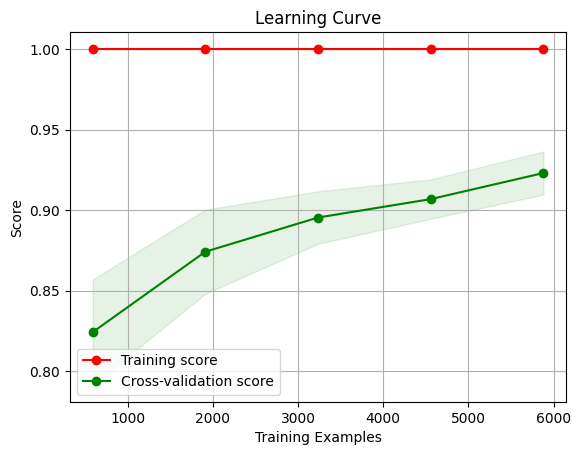

In [ ]:
plot_learning_curve(classifier_xgb, x_train, y_train)

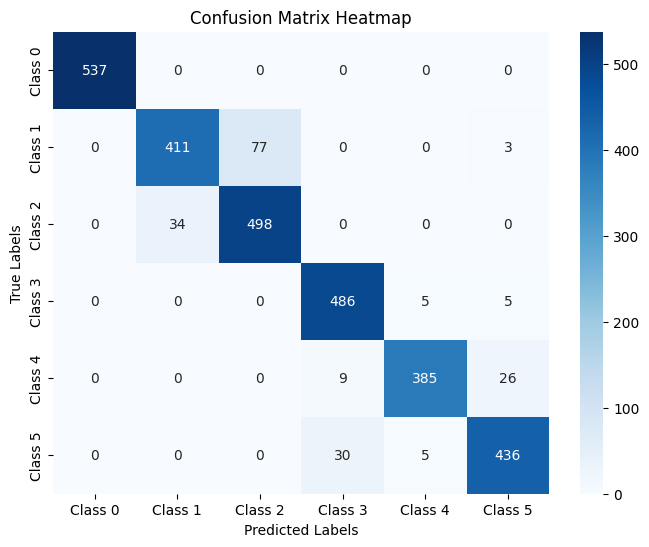

In [ ]:
cm_heatmap(cm_xgb)

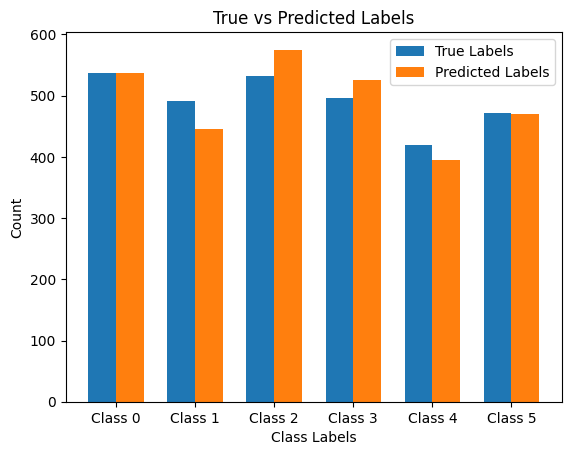

In [ ]:
true_counts_xgb, pred_counts_xgb = sixLabel_count_dataCleaning(y_pred_xgb)
bar_chart(true_counts_xgb, pred_counts_xgb)

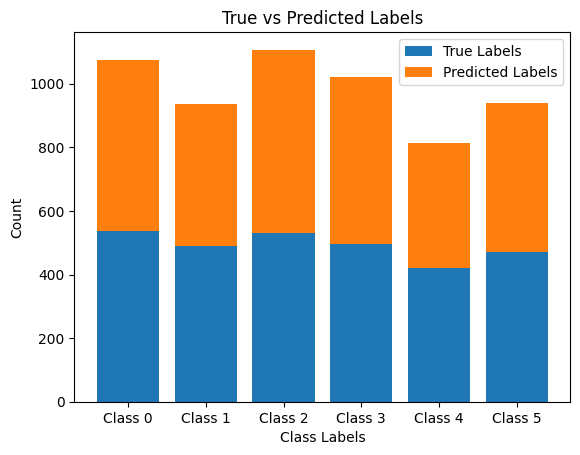

In [ ]:
stacked_bar_chart(true_counts_xgb, pred_counts_xgb)

# **10 LightGBM Classifier**

In [ ]:
import lightgbm as lgb

classifier_lgb = lgb.LGBMClassifier()
classifier_lgb.fit(x_train, y_train)

LGBMClassifier()

In [ ]:
y_pred_lgb = classifier_lgb.predict(x_test)

In [ ]:
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
print("Accuracy (LGB):", accuracy_lgb)

Accuracy (LGB): 0.9314557176789956


In [ ]:
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
print("Confusion Matrix (LGB):")
print(cm_lgb)

Confusion Matrix (LGB):
[[537   0   0   0   0   0]
 [  0 408  82   0   0   1]
 [  0  39 493   0   0   0]
 [  0   0   0 486   5   5]
 [  0   0   0   6 387  27]
 [  0   0   0  30   7 434]]


In [ ]:
report_lgb = classification_report(y_test, y_pred_lgb)
print("Classification Report (LGB):")
print(report_lgb)

Classification Report (LGB):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.91      0.83      0.87       491
           2       0.86      0.93      0.89       532
           3       0.93      0.98      0.95       496
           4       0.97      0.92      0.95       420
           5       0.93      0.92      0.93       471

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947



In [ ]:
hamming_loss_lgb = hamming_loss(y_test, y_pred_lgb)
print("Hamming Loss (LGB):", hamming_loss_lgb)

Hamming Loss (LGB): 0.06854428232100442


In [ ]:
micro_f1_lgb = f1_score(y_test, y_pred_lgb, average='micro')
macro_f1_lgb = f1_score(y_test, y_pred_lgb, average='macro')

print("Micro-average F1-score (LGB):", micro_f1_lgb)
print("Macro-average F1-score (LGB):", macro_f1_lgb)

Micro-average F1-score (LGB): 0.9314557176789956
Macro-average F1-score (LGB): 0.9309788411082218


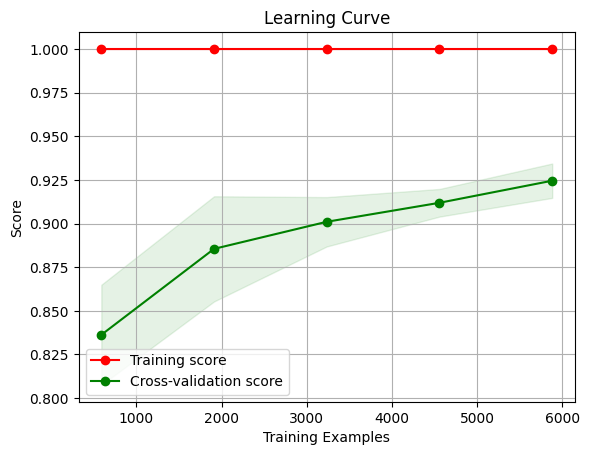

In [ ]:
plot_learning_curve(classifier_lgb, x_train, y_train)

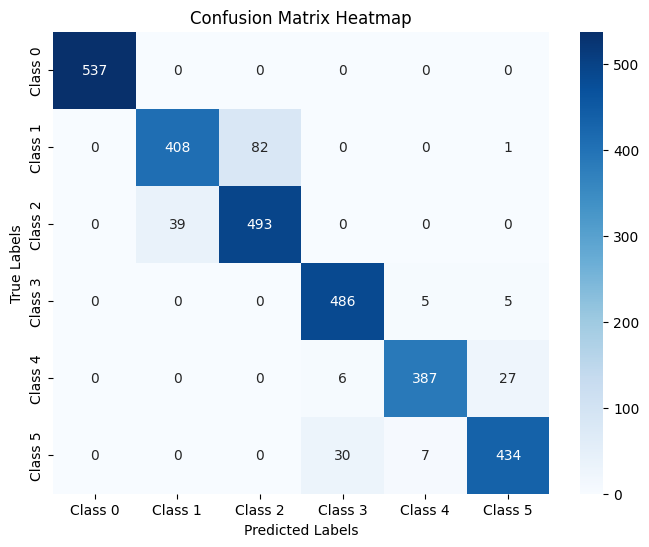

In [ ]:
cm_heatmap(cm_lgb)

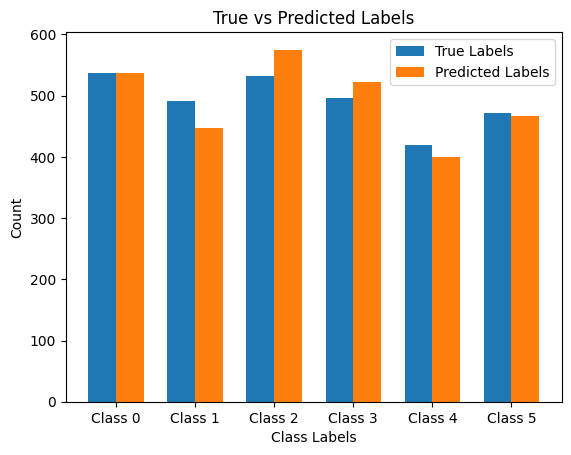

In [ ]:
true_counts_lgb, pred_counts_lgb = sixLabel_count_dataCleaning(y_pred_lgb)
bar_chart(true_counts_lgb, pred_counts_lgb)

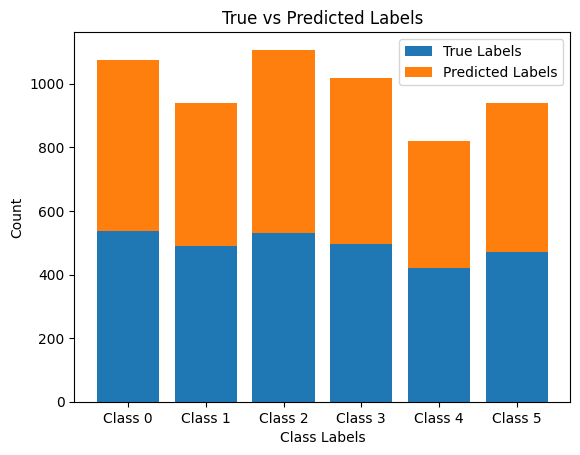

In [ ]:
stacked_bar_chart(true_counts_lgb, pred_counts_lgb)

# **11 Quadratic Discriminant Analysis**

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
classifier_qda = QuadraticDiscriminantAnalysis()
classifier_qda.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


QuadraticDiscriminantAnalysis()

In [ ]:
y_pred_qda = classifier_qda.predict(x_test)

In [ ]:
accuracy_qda = accuracy_score(y_test, y_pred_qda)
print("Accuracy (QDA):", accuracy_qda)

Accuracy (QDA): 0.7695961995249406


In [ ]:
cm_qda = confusion_matrix(y_test, y_pred_qda)
print("Confusion Matrix (QDA):")
print(cm_qda)

Confusion Matrix (QDA):
[[537   0   0   0   0   0]
 [  3 364 111   1   9   3]
 [  0  22 480   1  26   3]
 [  0   0   0 155 322  19]
 [  0   0   0   0 411   9]
 [  0   0   0   3 147 321]]


In [ ]:
report_qda = classification_report(y_test, y_pred_qda)
print("Classification Report (QDA):")
print(report_qda)

Classification Report (QDA):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       537
           1       0.94      0.74      0.83       491
           2       0.81      0.90      0.85       532
           3       0.97      0.31      0.47       496
           4       0.45      0.98      0.62       420
           5       0.90      0.68      0.78       471

    accuracy                           0.77      2947
   macro avg       0.85      0.77      0.76      2947
weighted avg       0.86      0.77      0.77      2947



In [ ]:
hamming_loss_qda = hamming_loss(y_test, y_pred_qda)
print("Hamming Loss (QDA):", hamming_loss_qda)

Hamming Loss (QDA): 0.23040380047505937


In [ ]:
micro_f1_qda = f1_score(y_test, y_pred_qda, average='micro')
macro_f1_qda = f1_score(y_test, y_pred_qda, average='macro')

print("Micro-average F1-score (QDA):", micro_f1_qda)
print("Macro-average F1-score (QDA):", macro_f1_qda)

Micro-average F1-score (QDA): 0.7695961995249406
Macro-average F1-score (QDA): 0.757950200252728


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/usr/local/lib/python3.10/dist-packages/sklearn/disc

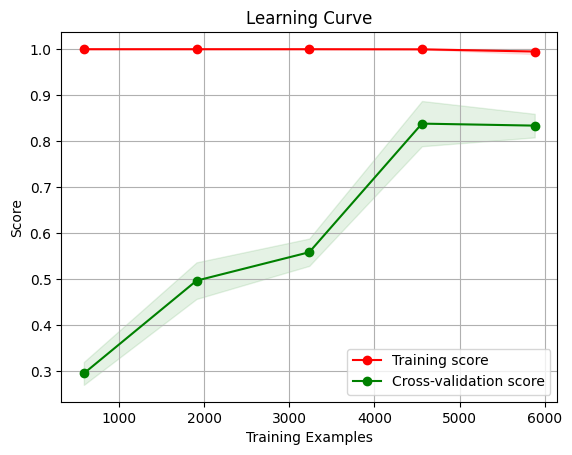

In [ ]:
plot_learning_curve(classifier_qda, x_train, y_train)

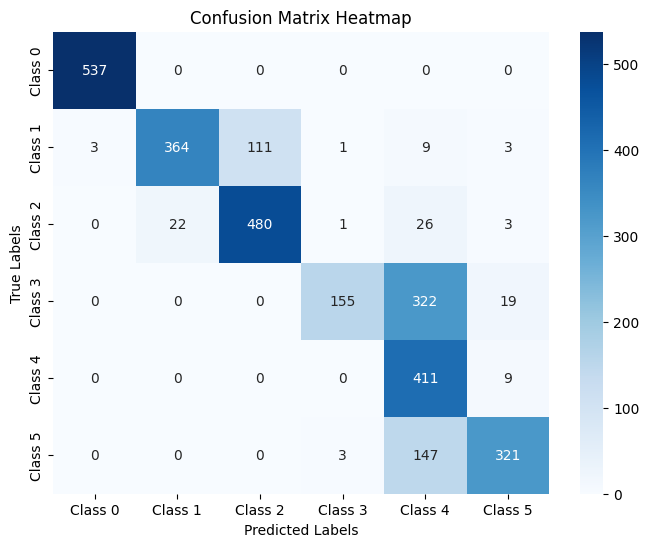

In [ ]:
cm_heatmap(cm_qda)

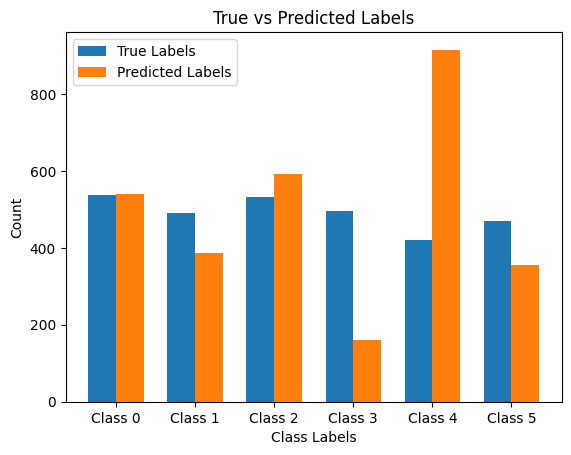

In [ ]:
true_counts_qda, pred_counts_qda = sixLabel_count_dataCleaning(y_pred_qda)
bar_chart(true_counts_qda, pred_counts_qda)

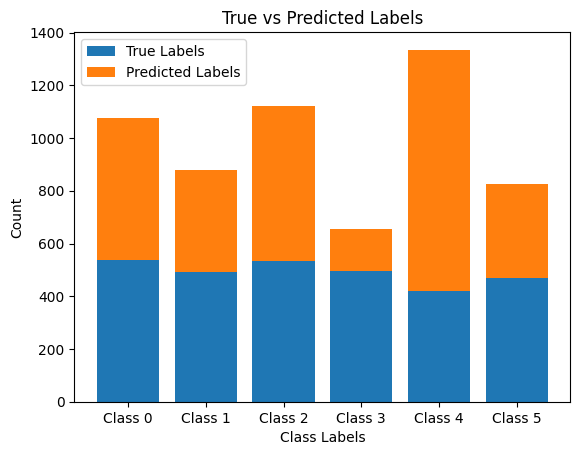

In [ ]:
stacked_bar_chart(true_counts_qda, pred_counts_qda)

# **12 Linear Discriminant Analysis**

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
classifier_lda = LinearDiscriminantAnalysis(solver='eigen', shrinkage=0.00008, priors=None
                                            , n_components=None, store_covariance=True
                                            , tol=0.00000000001, covariance_estimator=None)
classifier_lda.fit(x_train, y_train)

LinearDiscriminantAnalysis(shrinkage=8e-05, solver='eigen',
                           store_covariance=True, tol=1e-11)

In [ ]:
y_pred_lda = classifier_lda.predict(x_test)

In [ ]:
accuracy_lda = accuracy_score(y_test, y_pred_lda)
print("Accuracy (LDA):", accuracy_lda)

Accuracy (LDA): 0.9633525619273838


In [ ]:
# Tuning for solver & shrinkage

best_acc_lda = 0
best_shrinkage = 0
best_shrinkage_list = []
best_solver = 0
best_solver_list = []

for i in ['lsqr', 'eigen']:
    for j in range(1, 10000000, 500):
        classifier_lda = LinearDiscriminantAnalysis(solver = i
                                                    , shrinkage = j/1000000000
                                                    , priors=None
                                                    , n_components=None
                                                    , store_covariance=False
                                                    , tol=1.0e-8
                                                    , covariance_estimator=None
                                                    )
        classifier_lda.fit(x_train, y_train)
        y_pred_lda = classifier_lda.predict(x_test)
        new_accuracy_lda = accuracy_score(y_test, y_pred_lda)
        print("with shrinkage =", j/1000000000, "and solver", i, " , the Accuracy is:", new_accuracy_lda)

        if new_accuracy_lda > best_acc_lda:
            best_shrinkage_leaf_list = []
            best_solver_list = []
            best_shrinkage_leaf = j/1000000000
            best_acc_lda = new_accuracy_lda
            best_solver = i

        elif new_accuracy_lda == best_acc_lda:
            best_shrinkage_list.append(best_shrinkage)
            best_solver_list.append(best_solver)


print("The best model has Accuracy", best_acc_lda, "when we use solver", best_solver, "with shrinkage =", best_shrinkage)

Streaming output truncated to the last 5000 lines.
with shrinkage = 0.004086501 and solver lsqr  , the Accuracy is: 0.9653885307091958
with shrinkage = 0.004087001 and solver lsqr  , the Accuracy is: 0.9653885307091958
with shrinkage = 0.004087501 and solver lsqr  , the Accuracy is: 0.9653885307091958
with shrinkage = 0.004088001 and solver lsqr  , the Accuracy is: 0.9653885307091958
with shrinkage = 0.004088501 and solver lsqr  , the Accuracy is: 0.9653885307091958
with shrinkage = 0.004089001 and solver lsqr  , the Accuracy is: 0.9653885307091958
with shrinkage = 0.004089501 and solver lsqr  , the Accuracy is: 0.9653885307091958
with shrinkage = 0.004090001 and solver lsqr  , the Accuracy is: 0.9653885307091958
with shrinkage = 0.004090501 and solver lsqr  , the Accuracy is: 0.9653885307091958
with shrinkage = 0.004091001 and solver lsqr  , the Accuracy is: 0.9653885307091958
with shrinkage = 0.004091501 and solver lsqr  , the Accuracy is: 0.9653885307091958
with shrinkage = 0.004092

In [ ]:
classifier_lda = LinearDiscriminantAnalysis(solver = best_solver
                                            , shrinkage = best_shrinkage
                                            , priors = None
                                            , n_components = None
                                            , store_covariance = True
                                            , tol = 1.0e-8
                                            , covariance_estimator = None
                                            )
classifier_lda.fit(x_train, y_train)

In [ ]:
cm_lda = confusion_matrix(y_test, y_pred_lda)
print("Confusion Matrix (LDA):")
print(cm_lda)

Confusion Matrix (LDA):
[[537   0   0   0   0   0]
 [  0 438  52   0   0   1]
 [  0  22 510   0   0   0]
 [  0   0   0 490   0   6]
 [  0   0   0   1 405  14]
 [  0   0   0   9   0 462]]


In [ ]:
report_lda = classification_report(y_test, y_pred_lda)
print("Classification Report (LDA):")
print(report_lda)

Classification Report (LDA):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.95      0.89      0.92       491
           2       0.91      0.96      0.93       532
           3       0.98      0.99      0.98       496
           4       1.00      0.96      0.98       420
           5       0.96      0.98      0.97       471

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.97      0.96      0.96      2947



In [ ]:
hamming_loss_lda = hamming_loss(y_test, y_pred_lda)
print("Hamming Loss (LDA):", hamming_loss_lda)

Hamming Loss (LDA): 0.035629453681710214


In [ ]:
micro_f1_lda = f1_score(y_test, y_pred_lda, average='micro')
macro_f1_lda = f1_score(y_test, y_pred_lda, average='macro')

print("Micro-average F1-score (LDA):", micro_f1_lda)
print("Macro-average F1-score (LDA):", macro_f1_lda)

Micro-average F1-score (LDA): 0.9643705463182898
Macro-average F1-score (LDA): 0.9646335581159972


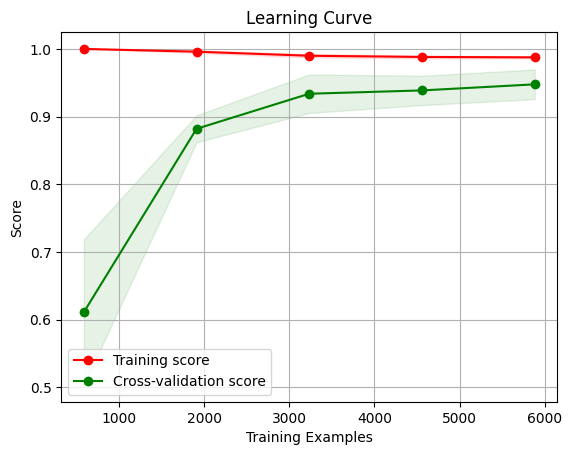

In [ ]:
plot_learning_curve(classifier_lda, x_train, y_train)

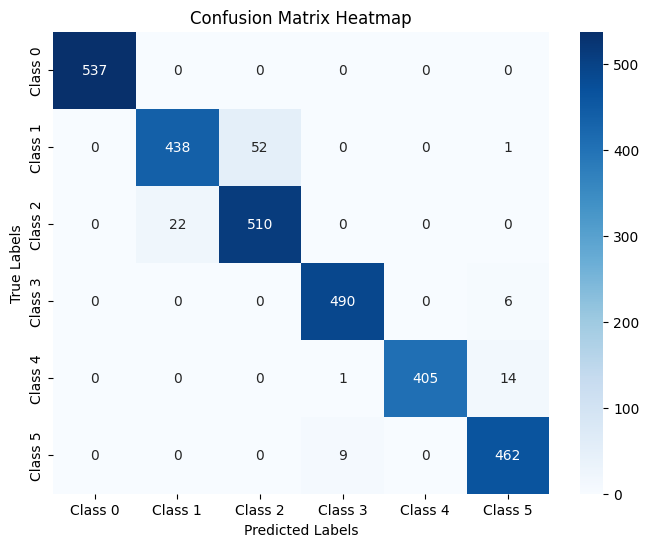

In [ ]:
cm_heatmap(cm_lda)

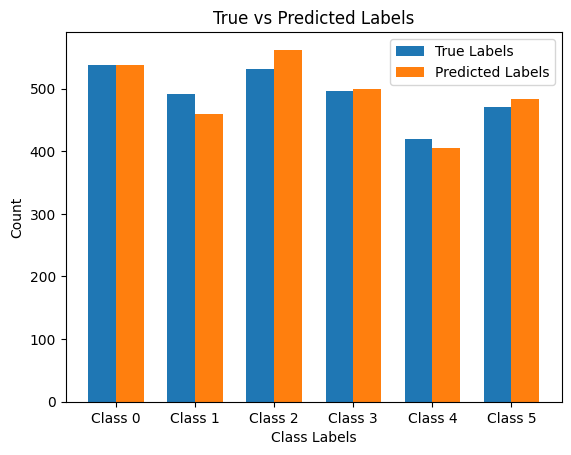

In [ ]:
true_counts_lda, pred_counts_lda = sixLabel_count_dataCleaning(y_pred_lda)
bar_chart(true_counts_lda, pred_counts_lda)

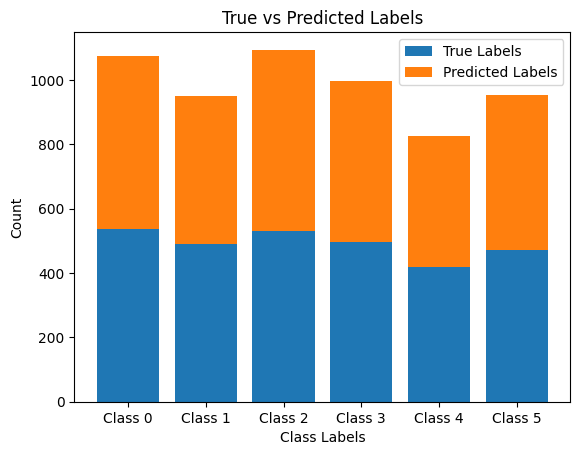

In [ ]:
stacked_bar_chart(true_counts_lda, pred_counts_lda)

# **13 Perceptron**

In [ ]:
from sklearn.linear_model import Perceptron
classifier_perceptron = Perceptron()
classifier_perceptron.fit(x_train, y_train)

Perceptron()

In [ ]:
y_pred_perceptron = classifier_perceptron.predict(x_test)

In [ ]:
accuracy_perceptron = accuracy_score(y_test, y_pred_perceptron)
print("Accuracy (Perceptron):", accuracy_perceptron)

Accuracy (Perceptron): 0.9552086868001357


In [ ]:
cm_perceptron = confusion_matrix(y_test, y_pred_perceptron)
print("Confusion Matrix (Perceptron):")
print(cm_perceptron)

Confusion Matrix (Perceptron):
[[537   0   0   0   0   0]
 [  4 429  52   0   0   6]
 [  0  21 506   5   0   0]
 [  0   0   0 492   2   2]
 [  0   0   0   5 404  11]
 [  0   0   0  24   0 447]]


In [ ]:
report_perceptron = classification_report(y_test, y_pred_perceptron)
print("Classification Report (Perceptron):")
print(report_perceptron)

Classification Report (Perceptron):
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       537
           1       0.95      0.87      0.91       491
           2       0.91      0.95      0.93       532
           3       0.94      0.99      0.96       496
           4       1.00      0.96      0.98       420
           5       0.96      0.95      0.95       471

    accuracy                           0.96      2947
   macro avg       0.96      0.95      0.96      2947
weighted avg       0.96      0.96      0.96      2947



In [ ]:
hamming_loss_perceptron = hamming_loss(y_test, y_pred_perceptron)
print("Hamming Loss (Perceptron):", hamming_loss_perceptron)


Hamming Loss (Perceptron): 0.04479131319986427


In [ ]:
micro_f1_perceptron = f1_score(y_test, y_pred_perceptron, average='micro')
macro_f1_perceptron = f1_score(y_test, y_pred_perceptron, average='macro')

print("Micro-average F1-score (Perceptron):", micro_f1_perceptron)
print("Macro-average F1-score (Perceptron):", macro_f1_perceptron)

Micro-average F1-score (Perceptron): 0.9552086868001357
Macro-average F1-score (Perceptron): 0.9552768079988673


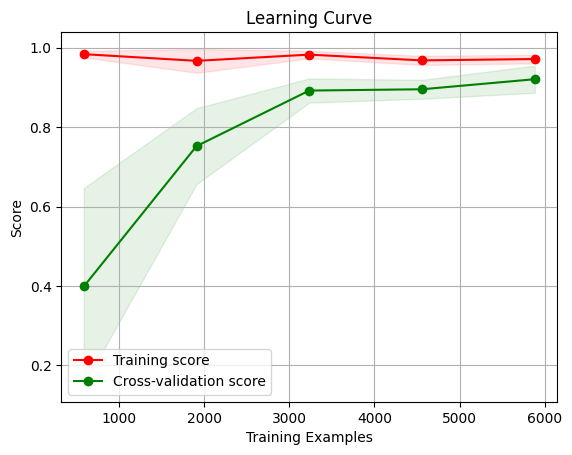

In [ ]:
plot_learning_curve(classifier_perceptron, x_train, y_train)

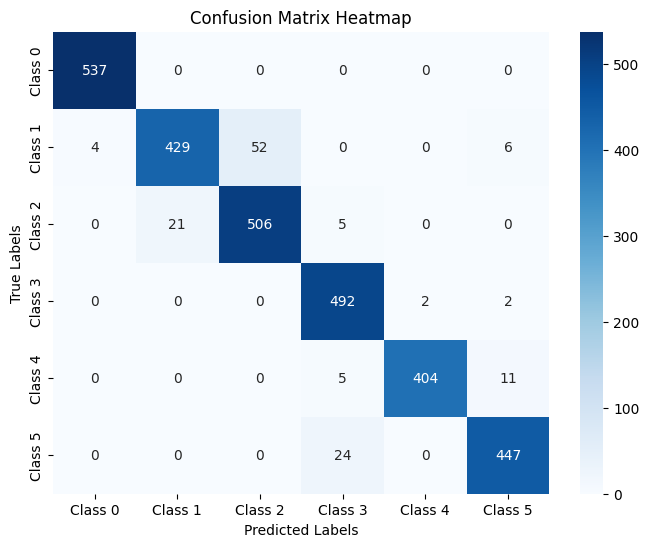

In [ ]:
cm_heatmap(cm_perceptron)

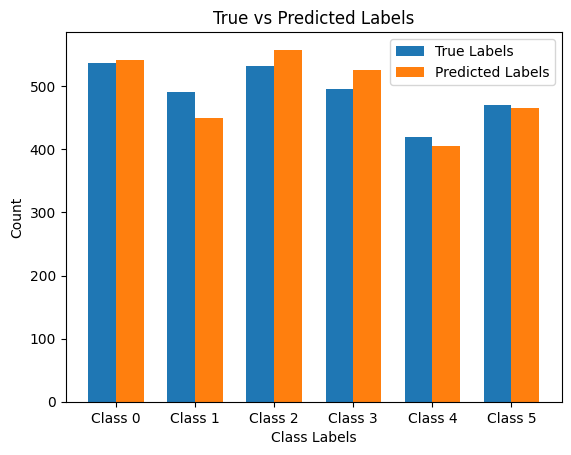

In [ ]:
true_counts_perceptron, pred_counts_perceptron = sixLabel_count_dataCleaning(y_pred_perceptron)
bar_chart(true_counts_perceptron, pred_counts_perceptron)

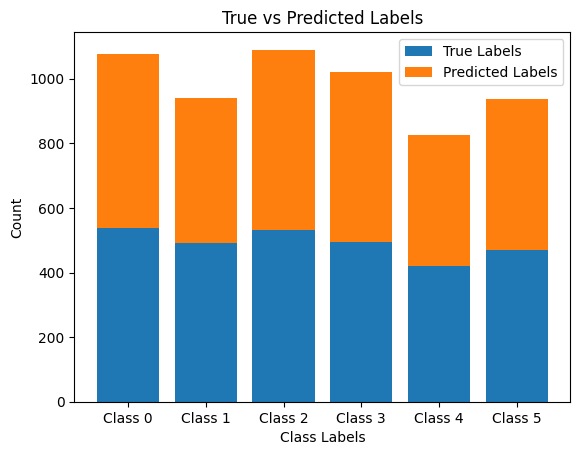

In [ ]:
stacked_bar_chart(true_counts_perceptron, pred_counts_perceptron)

# **14 Nearest Centroid**

In [ ]:
from sklearn.neighbors import NearestCentroid
classifier_nc = NearestCentroid(metric='euclidean',shrink_threshold=0.5)
classifier_nc.fit(x_train, y_train)

NearestCentroid(shrink_threshold=0.5)

In [ ]:
y_pred_nc = classifier_nc.predict(x_test)

In [ ]:
accuracy_nc = accuracy_score(y_test, y_pred_nc)
print("Accuracy (NC):", accuracy_nc)

Accuracy (NC): 0.7102137767220903


In [ ]:
# hyperparameter tuning

shrink_threshold = np.arange(0.2, 20, 0.2)
best_shrink_threshold = 0.00
best_ac_nc = 0.00
for i in shrink_threshold:
  classifier_nc = NearestCentroid(metric='euclidean',shrink_threshold=float(i))
  classifier_nc.fit(x_train, y_train)
  y_pred_nc = classifier_nc.predict(x_test)
  accuracy_nc = accuracy_score(y_test, y_pred_nc)
  print("Accuracy of NC with shrink threshold of", i, "is:", accuracy_nc)
  if best_ac_nc < accuracy_nc:
    best_shrink_threshold = i

Accuracy of NC with shrink threshold of 0.2 is: 0.7112317611129962
Accuracy of NC with shrink threshold of 0.4 is: 0.7105531048523923
Accuracy of NC with shrink threshold of 0.6000000000000001 is: 0.7095351204614863
Accuracy of NC with shrink threshold of 0.8 is: 0.7078384798099763
Accuracy of NC with shrink threshold of 1.0 is: 0.7061418391584663
Accuracy of NC with shrink threshold of 1.2 is: 0.7037665422463523
Accuracy of NC with shrink threshold of 1.4000000000000001 is: 0.7044451985069562
Accuracy of NC with shrink threshold of 1.6 is: 0.7105531048523923
Accuracy of NC with shrink threshold of 1.8 is: 0.7265015269765863
Accuracy of NC with shrink threshold of 2.0 is: 0.7475398710553105
Accuracy of NC with shrink threshold of 2.2 is: 0.7624703087885986
Accuracy of NC with shrink threshold of 2.4000000000000004 is: 0.7716321683067526
Accuracy of NC with shrink threshold of 2.6000000000000005 is: 0.7872412623006447
Accuracy of NC with shrink threshold of 2.8000000000000003 is: 0.7960

In [ ]:
cm_nc = confusion_matrix(y_test, y_pred_nc)
print("Confusion Matrix (NC):")
print(cm_nc)

Confusion Matrix (NC):
[[529   0   4   1   0   3]
 [  0 219 266   1   0   5]
 [  0  43 486   2   0   1]
 [  0   0   0 391  44  61]
 [  0   0   0 141 219  60]
 [  0   0   0 201  18 252]]


In [ ]:
report_nc = classification_report(y_test, y_pred_nc)
print("Classification Report (NC):")
print(report_nc)

Classification Report (NC):
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       537
           1       0.84      0.45      0.58       491
           2       0.64      0.91      0.75       532
           3       0.53      0.79      0.63       496
           4       0.78      0.52      0.62       420
           5       0.66      0.54      0.59       471

    accuracy                           0.71      2947
   macro avg       0.74      0.70      0.70      2947
weighted avg       0.74      0.71      0.70      2947



In [ ]:
hamming_loss_nc = hamming_loss(y_test, y_pred_nc)
print("Hamming Loss (NC):", hamming_loss_nc)

Hamming Loss (NC): 0.28876823888700376


In [ ]:
micro_f1_nc = f1_score(y_test, y_pred_nc, average='micro')
macro_f1_nc = f1_score(y_test, y_pred_nc, average='macro')

print("Micro-average F1-score (NC):", micro_f1_nc)
print("Macro-average F1-score (NC):", macro_f1_nc)

Micro-average F1-score (NC): 0.7112317611129962
Macro-average F1-score (NC): 0.6964549923557392


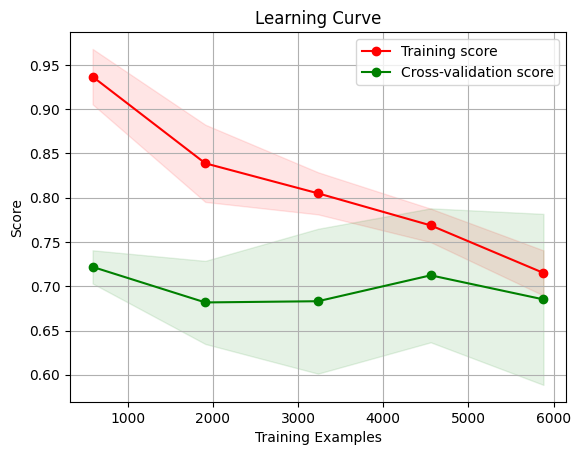

In [ ]:
plot_learning_curve(classifier_nc, x_train, y_train)

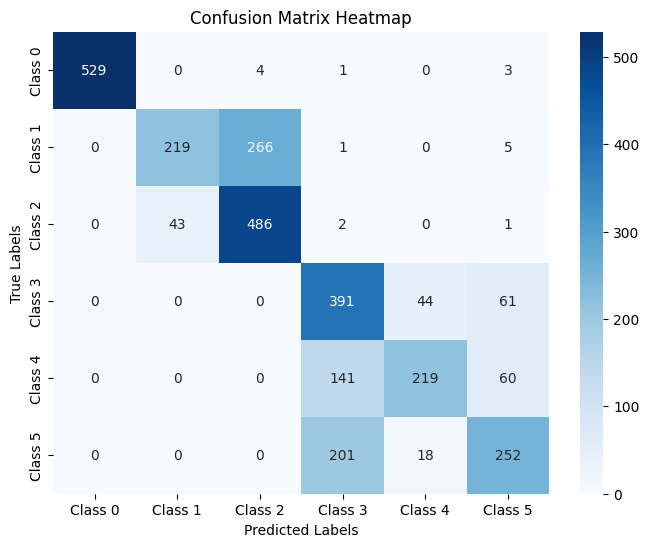

In [ ]:
cm_heatmap(cm_nc)

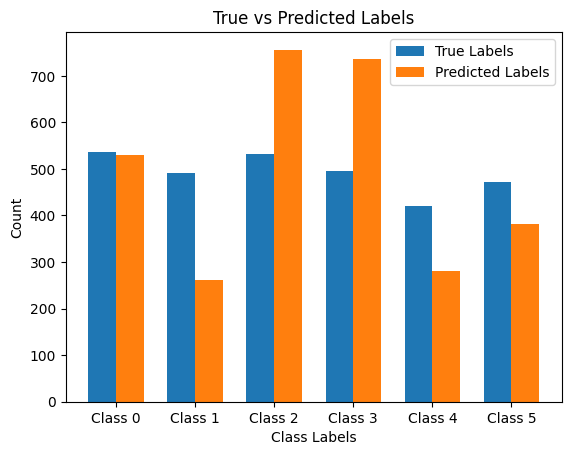

In [ ]:
true_counts_nc, pred_counts_nc = sixLabel_count_dataCleaning(y_pred_nc)
bar_chart(true_counts_nc, pred_counts_nc)

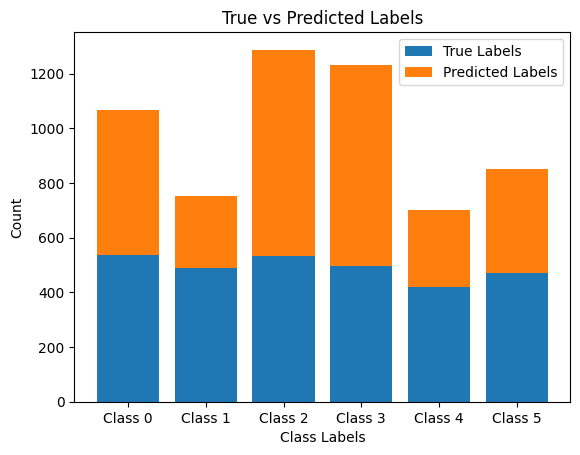

In [ ]:
stacked_bar_chart(true_counts_nc, pred_counts_nc)

# **15 Gradient Boosting**

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
classifier_gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
classifier_gb.fit(x_train, y_train)

GradientBoostingClassifier(random_state=42)

In [ ]:
y_pred_gb = classifier_gb.predict(x_test)

In [ ]:
accuracy_gb = accuracy_score(y_test, y_pred_gb)
print("Accuracy (GB):", accuracy_gb)

Accuracy (GB): 0.9372242958941296


In [ ]:
cm_gb = confusion_matrix(y_test, y_pred_gb)
print("Confusion Matrix (GB):")
print(cm_gb)

Confusion Matrix (GB):
[[537   0   0   0   0   0]
 [  0 414  75   0   0   2]
 [  0  34 498   0   0   0]
 [  0   0   0 487   4   5]
 [  0   0   1   7 387  25]
 [  0   1   0  26   5 439]]


In [ ]:
report_gb = classification_report(y_test, y_pred_gb)
print("Classification Report (GB):")
print(report_gb)

Classification Report (GB):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.92      0.84      0.88       491
           2       0.87      0.94      0.90       532
           3       0.94      0.98      0.96       496
           4       0.98      0.92      0.95       420
           5       0.93      0.93      0.93       471

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



In [ ]:
hamming_loss_gb = hamming_loss(y_test, y_pred_gb)
print("Hamming Loss (GB):", hamming_loss_gb)

Hamming Loss (GB): 0.06277570410587038


In [ ]:
micro_f1_gb = f1_score(y_test, y_pred_gb, average='micro')
macro_f1_gb = f1_score(y_test, y_pred_gb, average='macro')

print("Micro-average F1-score (GB):", micro_f1_gb)
print("Macro-average F1-score (GB):", macro_f1_gb)

Micro-average F1-score (GB): 0.9372242958941296
Macro-average F1-score (GB): 0.9367739727299246


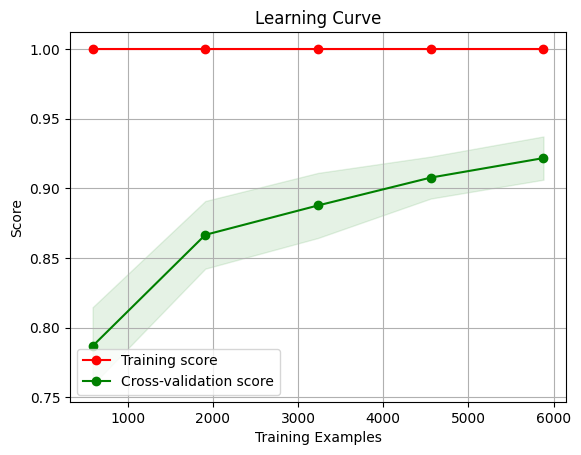

In [ ]:
plot_learning_curve(classifier_gb, x_train, y_train)

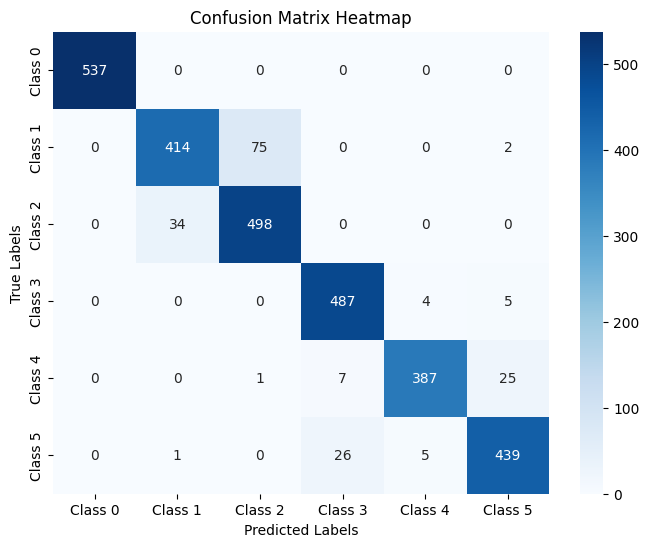

In [ ]:
cm_heatmap(cm_gb)

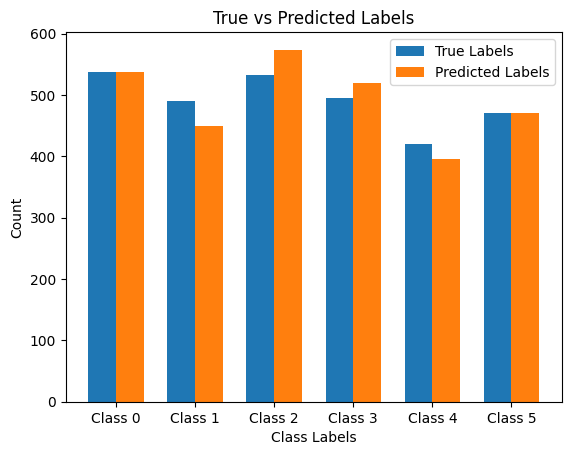

In [ ]:
true_counts_gb, pred_counts_gb = sixLabel_count_dataCleaning(y_pred_gb)
bar_chart(true_counts_gb, pred_counts_gb)

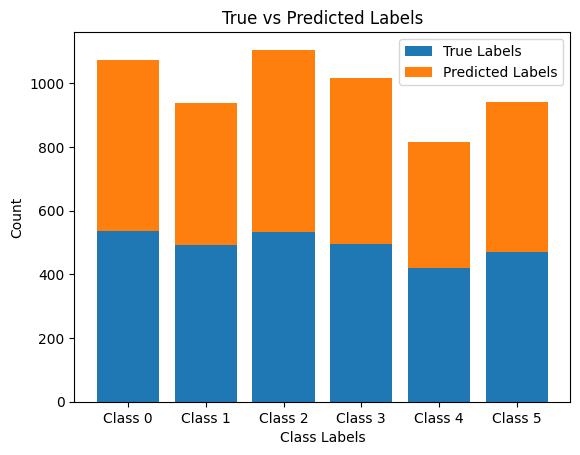

In [ ]:
stacked_bar_chart(true_counts_gb, pred_counts_gb)

# **16 Ridge Regression**

In [ ]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import train_test_split
classifier_ridge = RidgeClassifier()
classifier_ridge.fit(x_train, y_train)

RidgeClassifier()

In [ ]:
y_pred_ridge = classifier_ridge.predict(x_test)

In [ ]:
accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
print("Accuracy (ridge):", accuracy_ridge)

Accuracy (ridge): 0.9579233118425518


In [ ]:
cm_ridge = confusion_matrix(y_test, y_pred_ridge)
print("Confusion Matrix (ridge):")
print(cm_ridge)

Confusion Matrix (ridge):
[[517   0  20   0   0   0]
 [  0 431  58   0   0   2]
 [  0  21 511   0   0   0]
 [  0   0   0 492   0   4]
 [  0   0   0   2 411   7]
 [  0   0   0  10   0 461]]


In [ ]:
report_ridge = classification_report(y_test, y_pred_ridge)
print("Classification Report (RR):")
print(report_ridge)

Classification Report (RR):
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       537
           1       0.95      0.88      0.91       491
           2       0.87      0.96      0.91       532
           3       0.98      0.99      0.98       496
           4       1.00      0.98      0.99       420
           5       0.97      0.98      0.98       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



In [ ]:
hamming_loss_ridge = hamming_loss(y_test, y_pred_ridge)
print("Hamming Loss (ridge):", hamming_loss_ridge)

Hamming Loss (ridge): 0.04207668815744825


In [ ]:
micro_f1_ridge = f1_score(y_test, y_pred_ridge, average='micro')
macro_f1_ridge = f1_score(y_test, y_pred_ridge, average='macro')

print("Micro-average F1-score (ridge):", micro_f1_ridge)
print("Macro-average F1-score (ridge):", macro_f1_ridge)

Micro-average F1-score (ridge): 0.9579233118425518
Macro-average F1-score (ridge): 0.9592742728298141


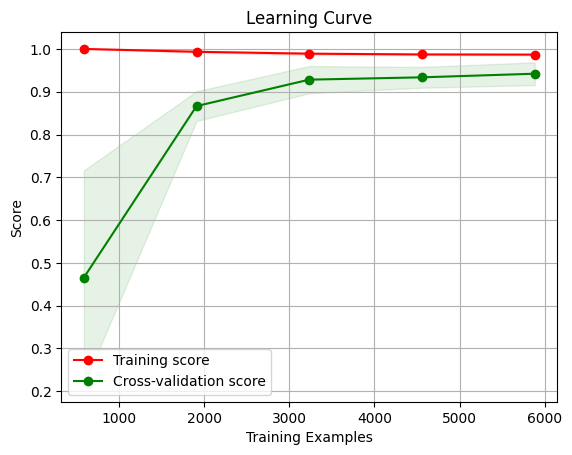

In [ ]:
plot_learning_curve(classifier_ridge, x_train, y_train)

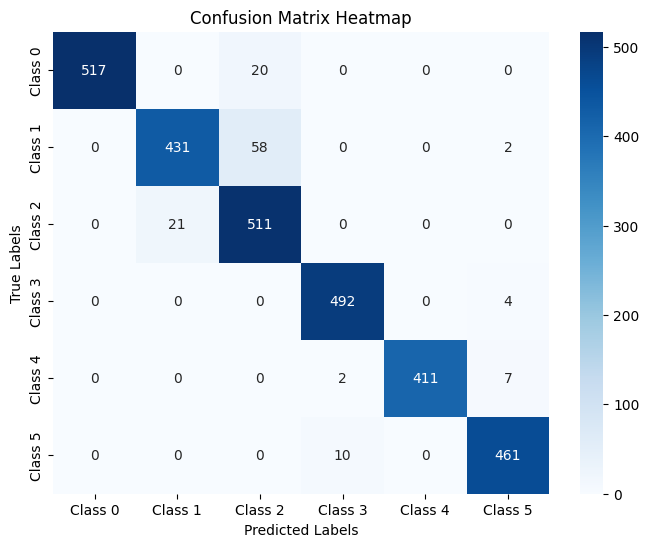

In [ ]:
cm_heatmap(cm_ridge)

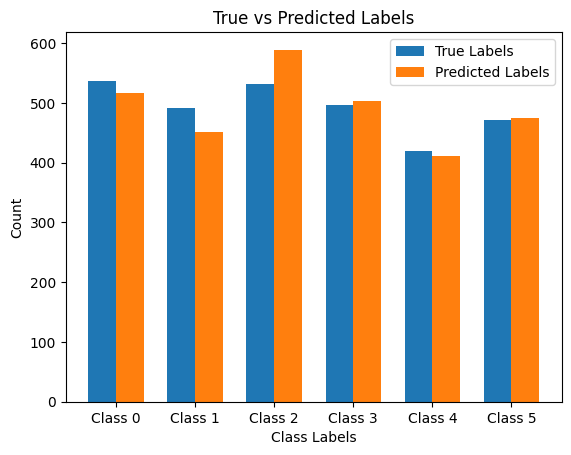

In [ ]:
true_counts_ridge, pred_counts_ridge = sixLabel_count_dataCleaning(y_pred_ridge)
bar_chart(true_counts_ridge, pred_counts_ridge)

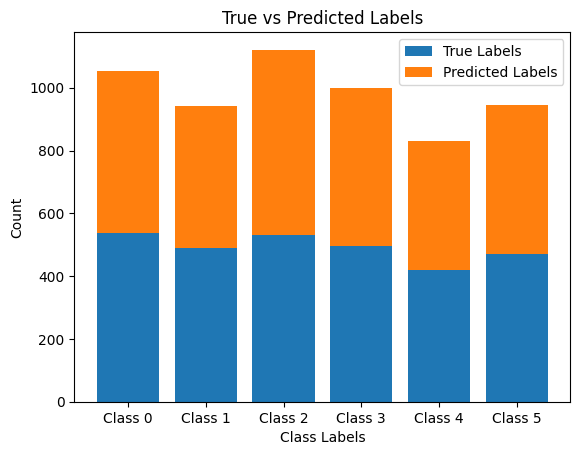

In [ ]:
stacked_bar_chart(true_counts_ridge, pred_counts_ridge)

# **17 Probabilistic SVM**

In [ ]:
from sklearn.svm import SVC
classifier_psvm = SVC(kernel = 'linear', probability=True, random_state = 0)
classifier_psvm.fit(x_train, y_train)

SVC(kernel='linear', probability=True, random_state=0)

In [ ]:
y_pred_psvm = classifier_psvm.predict(x_test)

In [ ]:
accuracy_psvm = accuracy_score(y_test, y_pred_psvm)
print("Accuracy (PSVM):", accuracy_psvm)

Accuracy (PSVM): 0.9633525619273838


In [ ]:
cm_psvm = confusion_matrix(y_test, y_pred_psvm)
print("Confusion Matrix (PSVM):")
print(cm_psvm,)

Confusion Matrix (PSVM):
[[537   0   0   0   0   0]
 [  0 435  55   0   0   1]
 [  0  16 516   0   0   0]
 [  0   0   0 494   1   1]
 [  0   0   0   4 410   6]
 [  0   0   0  22   2 447]]


In [ ]:
report_psvm = classification_report(y_test, y_pred_psvm)
print("Classification Report (PSVM):")
print(report_psvm)

Classification Report (PSVM):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.96      0.89      0.92       491
           2       0.90      0.97      0.94       532
           3       0.95      1.00      0.97       496
           4       0.99      0.98      0.98       420
           5       0.98      0.95      0.97       471

    accuracy                           0.96      2947
   macro avg       0.97      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



In [ ]:
hamming_loss_psvm = hamming_loss(y_test, y_pred_psvm)
print("Hamming Loss (PSVM):", hamming_loss_psvm)

Hamming Loss (PSVM): 0.03664743807261622


In [ ]:
micro_f1_psvm = f1_score(y_test, y_pred_psvm, average='micro')
macro_f1_psvm = f1_score(y_test, y_pred_psvm, average='macro')

print("Micro-average F1-score (PSVM):", micro_f1_psvm)
print("Macro-average F1-score (PSVM):", macro_f1_psvm)

Micro-average F1-score (PSVM): 0.9633525619273838
Macro-average F1-score (PSVM): 0.9635790742787718


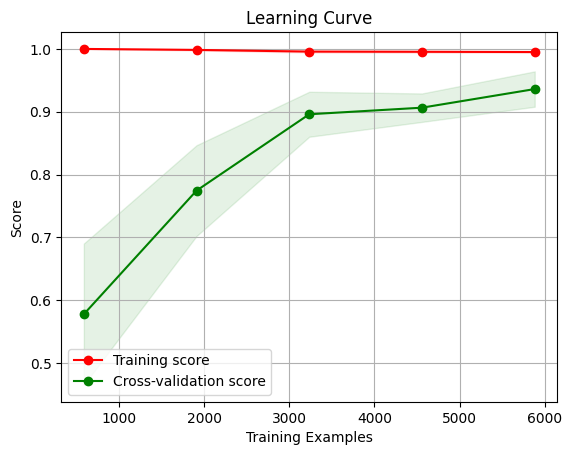

In [ ]:
plot_learning_curve(classifier_psvm, x_train, y_train)

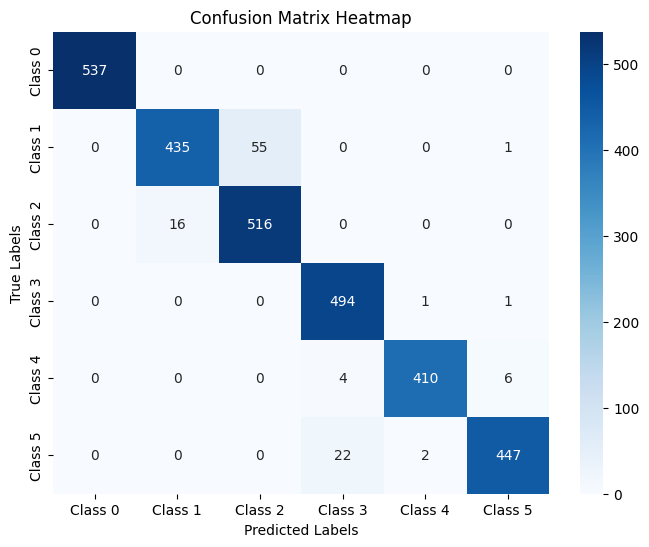

In [ ]:
cm_heatmap(cm_psvm)

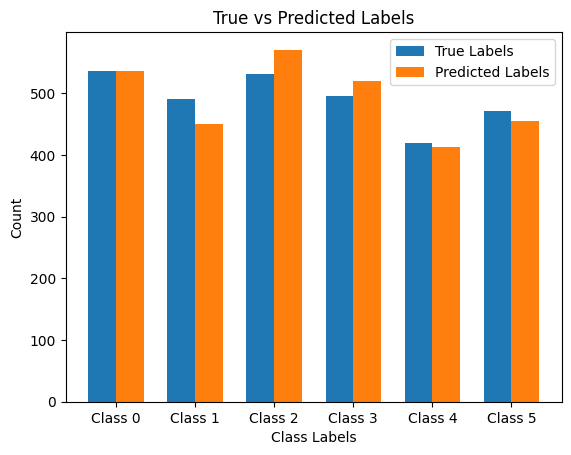

In [ ]:
true_counts_psvm, pred_counts_psvm = sixLabel_count_dataCleaning(y_pred_psvm)
bar_chart(true_counts_psvm, pred_counts_psvm)

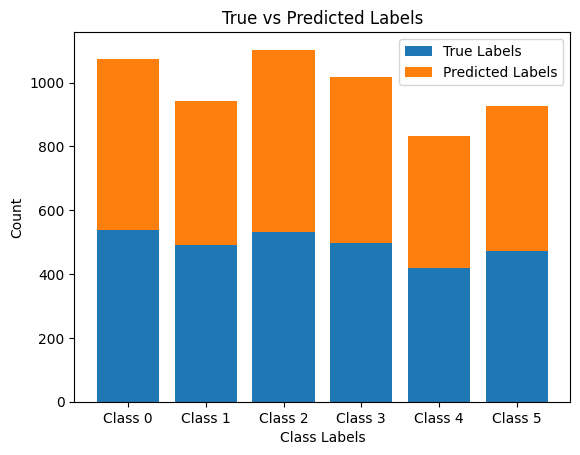

In [ ]:
stacked_bar_chart(true_counts_psvm, pred_counts_psvm)

# **18 Artifical Nural Networks**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
x_train = x_train.values
x_test = x_test.values

In [ ]:
model = nn.Sequential(
    nn.Linear(562, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 6)
)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [ ]:
for epoch in range(10):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

with torch.no_grad():
    x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)
    outputs = model(x_test_tensor)
    _, y_pred_ann = torch.max(outputs, 1)

In [ ]:
accuracy_ann = accuracy_score(y_test, y_pred_ann)
print("Accuracy (ANN):", accuracy_ann)

Accuracy (ANN): 0.9487614523243977


In [ ]:
cm_ann = confusion_matrix(y_test, y_pred_ann)
print("Confusion Matrix (ANN):")
print(cm_ann)

Confusion Matrix (ANN):
[[522   0  15   0   0   0]
 [  0 438  52   0   0   1]
 [  0  27 505   0   0   0]
 [  0   0   0 491   5   0]
 [  0   0   0   3 392  25]
 [  0   0   1  20   2 448]]


In [ ]:
report_ann = classification_report(y_test, y_pred_ann)
print("Classification Report (ANN):")
print(report_ann)

Classification Report (ANN):
              precision    recall  f1-score   support

           0       1.00      0.97      0.99       537
           1       0.94      0.89      0.92       491
           2       0.88      0.95      0.91       532
           3       0.96      0.99      0.97       496
           4       0.98      0.93      0.96       420
           5       0.95      0.95      0.95       471

    accuracy                           0.95      2947
   macro avg       0.95      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947



In [ ]:
hamming_loss_ann = hamming_loss(y_test, y_pred_ann)
print("Hamming Loss (ANN):", hamming_loss_ann)

Hamming Loss (ANN): 0.051238547675602306


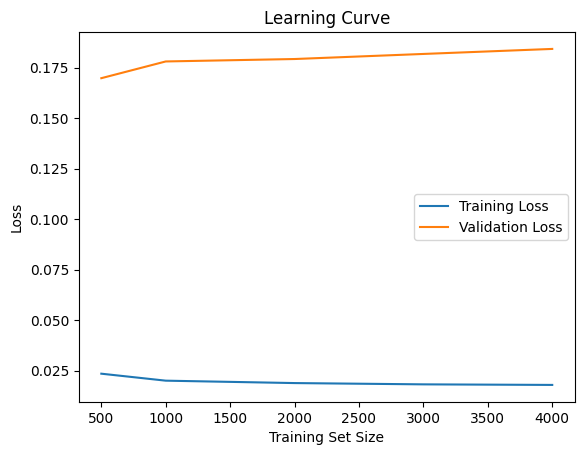

In [ ]:
def plot_learning_curve(model, X_train, y_train, X_test, y_test, train_sizes, batch_size=32, num_epochs=10):
    train_losses = []
    test_losses = []

    x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for size in train_sizes:
        subset_loader = DataLoader(train_dataset, batch_size=int(size), shuffle=True)
        train_loss = 0.0

        for _ in range(num_epochs):
            for inputs, labels in subset_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()

        train_loss /= (num_epochs * len(subset_loader))
        train_losses.append(train_loss)

        with torch.no_grad():
            x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
            y_test_tensor = torch.tensor(y_test, dtype=torch.long)
            outputs = model(x_test_tensor)
            test_loss = criterion(outputs, y_test_tensor)
            test_losses.append(test_loss.item())

    plt.plot(train_sizes, train_losses, label="Training Loss")
    plt.plot(train_sizes, test_losses, label="Validation Loss")
    plt.xlabel("Training Set Size")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.show()

# Define train_sizes, a list of different training set sizes you want to evaluate
train_sizes = [500, 1000, 2000, 3000, 4000]  # You can adjust this list as needed

# Call the plot_learning_curve function
plot_learning_curve(model, x_train, y_train, x_test, y_test, train_sizes)

In [ ]:
micro_f1_ann = f1_score(y_test, y_pred_ann, average='micro')
macro_f1_ann = f1_score(y_test, y_pred_ann, average='macro')

print("Micro-average F1-score (ANN):", micro_f1_ann)
print("Macro-average F1-score (ANN):", macro_f1_ann)

Micro-average F1-score (ANN): 0.9487614523243977
Macro-average F1-score (ANN): 0.9489785280233224


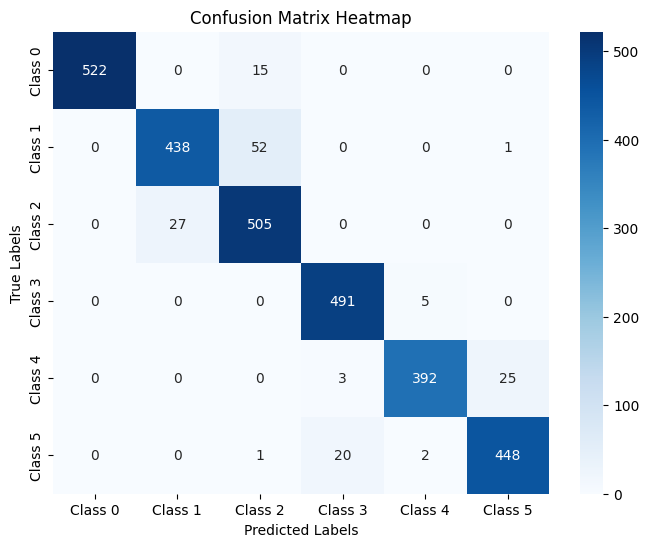

In [ ]:
cm_heatmap(cm_ann)

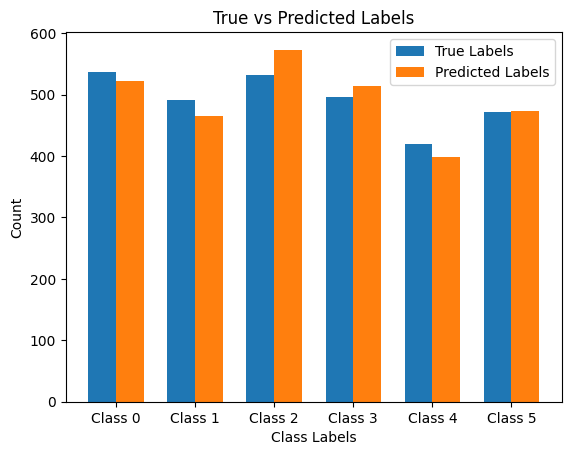

In [ ]:
true_counts_ann, pred_counts_ann = sixLabel_count_dataCleaning(y_pred_ann)
bar_chart(true_counts_ann, pred_counts_ann)

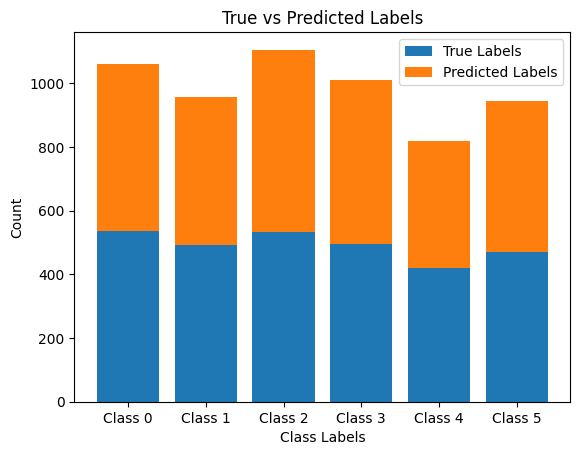

In [ ]:
stacked_bar_chart(true_counts_ann, pred_counts_ann)

# **19 Gaussian Process Classifier**
Note: Gaussian Process Classifier is computationaly expensive. So we take batches of size 500 from data and train the module

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
import pandas as pd

x_train = pd.DataFrame(x_train)
y_train = pd.DataFrame(y_train)
x_test = pd.DataFrame(x_test)
y_test = pd.DataFrame(y_test)

x_train2 = x_train.iloc[0:7310, :]
y_train2 = y_train.iloc[0:7310, :]
x_test2 = x_test.iloc[0:2890, :]
y_test2 = y_test.iloc[0:2890, :]

y_train2 = y_train2.values.ravel()
y_test2 = y_test2.values.ravel()

print(x_train2.shape)
print(y_train2.shape)
print(x_test2.shape)
print(y_test2.shape)

(7310, 562)
(7310,)
(2890, 562)
(2890,)


In [ ]:
batch_size = 170
y_pred_batches = []
classifier_gp = GaussianProcessClassifier(kernel=1.0 * RBF(1.0), random_state=0, n_restarts_optimizer=10)

for i in range(0, len(x_train2), batch_size):
    x_batch = x_train2[i:i+batch_size]
    y_batch = y_train2[i:i+batch_size]

    print("fitting through batch", (i+1)//170, "of the train data: samples", i+1, "to", i+170)

    classifier_gp.fit(x_batch, y_batch)

    # Predict on the test set using the trained classifier for this batch
    y_pred_batch = classifier_gp.predict(x_test2)
    y_pred_batches.append(y_pred_batch)

fitting through batch 0 of the train data: samples 1 to 170
fitting through batch 1 of the train data: samples 171 to 340
fitting through batch 2 of the train data: samples 341 to 510
fitting through batch 3 of the train data: samples 511 to 680
fitting through batch 4 of the train data: samples 681 to 850
fitting through batch 5 of the train data: samples 851 to 1020
fitting through batch 6 of the train data: samples 1021 to 1190
fitting through batch 7 of the train data: samples 1191 to 1360
fitting through batch 8 of the train data: samples 1361 to 1530
fitting through batch 9 of the train data: samples 1531 to 1700
fitting through batch 10 of the train data: samples 1701 to 1870
fitting through batch 11 of the train data: samples 1871 to 2040
fitting through batch 12 of the train data: samples 2041 to 2210
fitting through batch 13 of the train data: samples 2211 to 2380
fitting through batch 14 of the train data: samples 2381 to 2550
fitting through batch 15 of the train data: samp

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


fitting through batch 32 of the train data: samples 5441 to 5610
fitting through batch 33 of the train data: samples 5611 to 5780
fitting through batch 34 of the train data: samples 5781 to 5950
fitting through batch 35 of the train data: samples 5951 to 6120
fitting through batch 36 of the train data: samples 6121 to 6290
fitting through batch 37 of the train data: samples 6291 to 6460
fitting through batch 38 of the train data: samples 6461 to 6630
fitting through batch 39 of the train data: samples 6631 to 6800
fitting through batch 40 of the train data: samples 6801 to 6970
fitting through batch 41 of the train data: samples 6971 to 7140
fitting through batch 42 of the train data: samples 7141 to 7310


In [ ]:
y_pred_gp_final = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=np.array(y_pred_batches))

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix

conf_matrix = confusion_matrix(y_test2, y_pred_gp_final)
accuracy = accuracy_score(y_test2, y_pred_gp_final)

print("Confusion Matrix:")
print(conf_matrix)
print("Accuracy Score:", accuracy)

Confusion Matrix:
[[536   0   0   0   0   1]
 [  0 394  92   0   0   5]
 [  0  79 452   0   0   1]
 [  0   0   0 455  40   1]
 [  0   0   0  18 333  42]
 [  0   0   0   6  17 418]]
Accuracy Score: 0.8955017301038062


# **20 CatBoost Classifier**

In [ ]:
import catboost as ctb
model_CBC = ctb.CatBoostClassifier()
model_CBC.fit(x_train, y_train)
print(model_CBC)

Learning rate set to 0.087601
0:	learn: 1.4956257	total: 2.01s	remaining: 33m 25s
1:	learn: 1.3033374	total: 4.04s	remaining: 33m 36s
2:	learn: 1.1517879	total: 6.04s	remaining: 33m 27s
3:	learn: 1.0349940	total: 7.4s	remaining: 30m 43s
4:	learn: 0.9377226	total: 8.86s	remaining: 29m 23s
5:	learn: 0.8569664	total: 10.2s	remaining: 28m 9s
6:	learn: 0.7878787	total: 11.6s	remaining: 27m 31s
7:	learn: 0.7306967	total: 13.1s	remaining: 27m 7s
8:	learn: 0.6777946	total: 14.5s	remaining: 26m 32s
9:	learn: 0.6342432	total: 16s	remaining: 26m 26s
10:	learn: 0.5938402	total: 18.6s	remaining: 27m 49s
11:	learn: 0.5554918	total: 20.1s	remaining: 27m 36s
12:	learn: 0.5220350	total: 21.8s	remaining: 27m 37s
13:	learn: 0.4896347	total: 23.1s	remaining: 27m 8s
14:	learn: 0.4627527	total: 24.7s	remaining: 26m 59s
15:	learn: 0.4390982	total: 26.1s	remaining: 26m 47s
16:	learn: 0.4162366	total: 27.7s	remaining: 26m 38s
17:	learn: 0.3944906	total: 29.6s	remaining: 26m 55s
18:	learn: 0.3760714	total: 31.8

In [ ]:
y_pred_cbc = model_CBC.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred_cbc))
print(confusion_matrix(y_test, y_pred_cbc))
print(accuracy_score(y_test, y_pred_cbc))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.92      0.84      0.88       491
           2       0.87      0.93      0.90       532
           3       0.92      0.97      0.94       496
           4       0.98      0.90      0.94       420
           5       0.90      0.92      0.91       471

    accuracy                           0.93      2947
   macro avg       0.93      0.93      0.93      2947
weighted avg       0.93      0.93      0.93      2947

[[537   0   0   0   0   0]
 [  0 414  75   0   0   2]
 [  0  37 495   0   0   0]
 [  0   0   0 479   3  14]
 [  0   0   0   9 378  33]
 [  0   0   0  34   6 431]]
0.9277231082456736


# **21 AdaBoost Classifier**

In [ ]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

base_estimator = DecisionTreeClassifier(max_depth=10)
ada_boost = AdaBoostClassifier(base_estimator=base_estimator, n_estimators=50)
ada_boost.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=10))

In [ ]:
y_pred = ada_boost.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[537   0   0   0   0   0]
 [  0 405  86   0   0   0]
 [  0  37 495   0   0   0]
 [  0   0   0 483   6   7]
 [  0   0   0  12 369  39]
 [  0   0   0  33   4 434]]


0.9239904988123515

# **22 Bayesian Random Forests**

In [ ]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import Bunch


class BayesianRandomForest:
    def __init__(self, n_trees=100, n_samples=100):
        self.n_trees = n_trees
        self.n_samples = n_samples
        self.trees_ = []

    def fit(self, X, y):
        self.n_classes_ = len(np.unique(y))
        self.y_mean_ = np.mean(y)

        for _ in range(self.n_trees):
            tree = DecisionTreeClassifier(max_depth=2)  # Modify max_depth as needed
            bootstrapped_idx = np.random.choice(len(X), size=self.n_samples, replace=True)
            X_bootstrapped, y_bootstrapped = X.iloc[bootstrapped_idx], y[bootstrapped_idx]
            tree.fit(X_bootstrapped, y_bootstrapped)
            self.trees_.append(tree)

    def predict(self, X):
        predictions = np.zeros((X.shape[0], self.n_classes_))
        for tree in self.trees_:
            predictions += tree.predict_proba(X)
        return np.argmax(predictions, axis=1)

In [ ]:
model = BayesianRandomForest(n_trees=40, n_samples=80)
model.fit(x_train, y_train)

In [ ]:
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[537   0   0   0   0   0]
 [  0 413  77   0   0   1]
 [  0 121 407   1   0   3]
 [  0   0   0 472  13  11]
 [  0   0   0  75 306  39]
 [  0   0   0 110  17 344]]


0.8411944350186631

# **23 Bayesian Logistic Regression**

In [ ]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt

with pm.Model() as logistic_model:
    # Priors for the coefficients
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=6)
    beta = pm.Normal('beta', mu=0, sd=5, shape=(x_train.shape[1], 6))

    # Logistic regression model
    logits = pm.math.dot(x_train, beta) + alpha
    probabilities = pm.Deterministic('probabilities', tt.nnet.softmax(logits))

    # Categorical likelihood
    y_observed = pm.Categorical('y_observed', p=probabilities, observed=y_train)

In [ ]:
# Use the No-U-Turn Sampler (NUTS) for sampling
with logistic_model:
    trace = pm.sample(draws=300, tune=100, chains=1, cores=2, random_seed=42, return_inferencedata=False)

In [ ]:
# Extract the posterior samples from the trace
posterior_samples = trace.get_values('beta', combine=True)

# Calculate the posterior mean for the coefficients
beta_posterior_mean = np.mean(posterior_samples, axis=0)

# Calculate the logits for the test data
logits_test = np.dot(x_test, beta_posterior_mean) + trace['alpha'].mean()

# Compute the probabilities and predicted labels for the test data
probabilities_test = np.exp(logits_test) / np.sum(np.exp(logits_test), axis=1, keepdims=True)
predicted_labels = np.argmax(probabilities_test, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_test, predicted_labels)
print(cm)
accuracy_score(y_test, predicted_labels)

[[537   0   0   0   0   0]
 [  0 413  76   0   0   2]
 [  0  11 521   0   0   0]
 [  0   0   0 492   3   1]
 [  0   0   0   3 406  11]
 [  0   0   0  20   0 451]]


0.9569053274516457

# **24 Bayesian Naive Bayes**

In [ ]:
import pymc3 as pm
import numpy as np
import theano.tensor as tt

with pm.Model() as bayesian_naive_bayes:
    # Priors for the coefficients
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=len(np.unique(y_train)))
    beta = pm.Normal('beta', mu=0, sd=5, shape=(x_train.shape[1], len(np.unique(y_train))))

    # Calculate the log-likelihood for each class
    logits = pm.math.dot(x_train, beta) + alpha

    # Softmax transformation to obtain probabilities for each class
    probabilities = pm.Deterministic('probabilities', pm.math.softmax(logits))

    # Categorical likelihood
    y_observed = pm.Categorical('y_observed', p=probabilities, observed=y_train)

# Perform sampling using No-U-Turn Sampler (NUTS)
with bayesian_naive_bayes:
    trace = pm.sample(draws=2000, tune=1000, chains=2)

In [ ]:
with bayesian_naive_bayes:
    trace = pm.sample(draws=300, tune=100, chains=1, cores=2, random_seed=42, return_inferencedata=False)

In [ ]:
# Extract the posterior samples from the trace
posterior_samples = trace.get_values('beta', combine=True)

# Calculate the posterior mean for the coefficients
beta_posterior_mean = np.mean(posterior_samples, axis=0)

# Calculate the logits for the test data
logits_test = np.dot(x_test, beta_posterior_mean) + trace['alpha'].mean(axis=0)

# Compute the probabilities and predicted labels for the test data
probabilities_test = np.exp(logits_test - np.max(logits_test, axis=1, keepdims=True))
probabilities_test /= np.sum(probabilities_test, axis=1, keepdims=True)
predicted_labels = np.argmax(probabilities_test, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_test, predicted_labels)
print(cm)
accuracy_score(y_test, predicted_labels)

[[537   0   0   0   0   0]
 [  1 421  67   0   0   2]
 [  0  12 520   0   0   0]
 [  0   0   0 492   3   1]
 [  0   0   0   3 408   9]
 [  0   1   0  23   0 447]]


0.9586019681031558

# **25 Bayesian K-Nearest Neighbors**

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import pymc3 as pm

# Assuming you have defined the training and test datasets as x_train, y_train, x_test, and y_test

# Set the number of nearest neighbors for KNN
k_neighbors = 5

# Bayesian K-Nearest Neighbors
with pm.Model() as knn_model:
    # Priors for the class probabilities
    class_probs = pm.Dirichlet('class_probs', a=np.ones(6))

    # Gaussian likelihood for each class based on the distance to K-nearest neighbors
    likelihoods = []
    for i in range(6):
        likelihood_i = pm.Normal(f'likelihood_{i}', mu=class_probs[i], sd=0.1, observed=np.zeros(len(y_train)))
        likelihoods.append(likelihood_i)

In [ ]:
# Sampling from the posterior
with knn_model:
    trace = pm.sample(draws=300, tune=100, chains=1, cores=2, random_seed=42, return_inferencedata=False)

In [ ]:
# Extract the posterior samples from the trace
class_probs_samples = trace['class_probs']

# Take the posterior mean of the class probabilities
class_probs_mean = np.mean(class_probs_samples, axis=0)

# Bayesian K-Nearest Neighbors prediction on test data
knn_classifier = KNeighborsClassifier(n_neighbors=k_neighbors)
knn_classifier.fit(x_train, y_train)

# Make predictions on test data
predicted_labels = knn_classifier.predict(x_test)

In [ ]:
cm = confusion_matrix(y_test, predicted_labels)
print(cm)
accuracy_score(y_test, predicted_labels)

[[511  19   7   0   0   0]
 [  0 332 157   0   0   2]
 [  0  66 465   1   0   0]
 [  0   0   0 423  43  30]
 [  0   0   0  78 313  29]
 [  0   0   0 101  28 342]]


0.8096369189005769

# **26 Gaussian Process Regression**

In [ ]:
import numpy as np
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, RBF
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()
y_test_onehot = encoder.transform(y_test.reshape(-1, 1)).toarray()

np.random.seed(seed=42)
kernel = RBF() + WhiteKernel()
gpr = GaussianProcessRegressor(kernel=kernel, random_state=42)

gpr.fit(x_train, y_train_onehot)

GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         random_state=42)

In [ ]:
y_pred_probs = gpr.predict(x_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_gpr = accuracy_score(y_test, y_pred_labels)
cm_gpr = confusion_matrix(y_test, y_pred_labels)
print("GPR Confusion Matrix:")
print(cm_gpr)
print("GPR Accuracy:", accuracy_gpr)

GPR Confusion Matrix:
[[511   0  26   0   0   0]
 [  1 412  76   0   0   2]
 [  0   9 523   0   0   0]
 [  0   0   0 495   1   0]
 [  0   0   0   9 409   2]
 [  0   0   0  22  10 439]]
GPR Accuracy: 0.9463861554122837


# **27 Convolutional Neural Netwrks**

In [ ]:
if torch.cuda.is_available():
  print("Cuda (GPU support) is available and enabled!")
  device = torch.device("cuda")
else:
  print("Cuda (GPU support) is not available :(")
  device = torch.device("cpu")

Cuda (GPU support) is available and enabled!


In [ ]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

x_train_tensor = torch.tensor(x_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [ ]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, padding=2)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=128, out_channels=64, kernel_size=2)
        self.conv5 = nn.Conv1d(in_channels=64, out_channels=64, kernel_size=2)

        self.maxpool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.maxpool2 = nn.MaxPool1d(kernel_size=2, stride=1, padding=1)

        self.fc1 = nn.Linear(in_features=17984, out_features=800)
        self.fc2 = nn.Linear(in_features=800, out_features=10)

        self.offset = nn.Conv1d(in_channels=64, out_channels=18, kernel_size=3, padding=1)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(64)


    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.bn2(x)
        x = self.maxpool1(x)

        x = F.relu(self.conv4(x))
        x = self.bn3(x)
        x = F.relu(self.conv5(x))
        x = self.maxpool2(x)

        # Flatten the tensor before passing it to fully connected layers
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [ ]:
model = CNNModel()

summary(model, input_size=(128, 1, 562))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [128, 10]                 3,474
├─Conv1d: 1-1                            [128, 64, 564]            256
├─BatchNorm1d: 1-2                       [128, 64, 564]            128
├─Conv1d: 1-3                            [128, 64, 564]            12,352
├─Conv1d: 1-4                            [128, 128, 564]           24,704
├─BatchNorm1d: 1-5                       [128, 128, 564]           256
├─MaxPool1d: 1-6                         [128, 128, 282]           --
├─Conv1d: 1-7                            [128, 64, 281]            16,448
├─BatchNorm1d: 1-8                       [128, 64, 281]            128
├─Conv1d: 1-9                            [128, 64, 280]            8,256
├─MaxPool1d: 1-10                        [128, 64, 281]            --
├─Linear: 1-11                           [128, 1500]               26,977,500
├─Linear: 1-12                           [128, 10]     

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

model = model.to(device)
epochs = 30
loss_history = train(model, criterion, optimizer, epochs, train_loader)

Epoch 0 / 30: avg. loss of last 5 iterations 0.4790144503116608
Epoch 1 / 30: avg. loss of last 5 iterations 0.21645540297031401
Epoch 2 / 30: avg. loss of last 5 iterations 0.149892920255661
Epoch 3 / 30: avg. loss of last 5 iterations 0.1278855711221695
Epoch 4 / 30: avg. loss of last 5 iterations 0.0840387612581253
Epoch 5 / 30: avg. loss of last 5 iterations 0.08094167858362197
Epoch 6 / 30: avg. loss of last 5 iterations 0.06161143183708191
Epoch 7 / 30: avg. loss of last 5 iterations 0.056632987409830096
Epoch 8 / 30: avg. loss of last 5 iterations 0.05141301155090332
Epoch 9 / 30: avg. loss of last 5 iterations 0.034926995635032654
Epoch 10 / 30: avg. loss of last 5 iterations 0.0461877953261137
Epoch 11 / 30: avg. loss of last 5 iterations 0.0275409072637558
Epoch 12 / 30: avg. loss of last 5 iterations 0.042240827903151514
Epoch 13 / 30: avg. loss of last 5 iterations 0.025193392671644686
Epoch 14 / 30: avg. loss of last 5 iterations 0.024993456341326235
Epoch 15 / 30: avg. lo

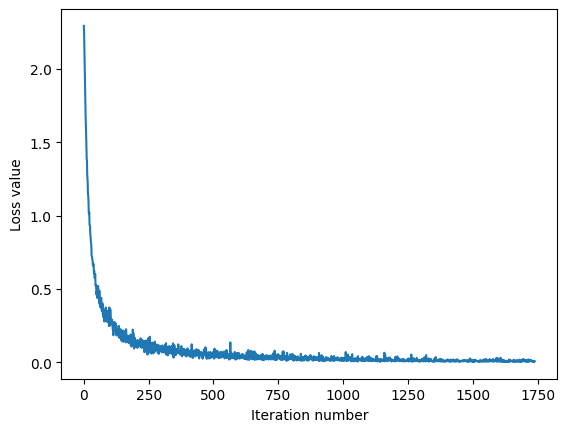

In [ ]:
plt.plot(loss_history)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [ ]:
with torch.no_grad():
    model.eval()
    outputs = model(x_test_tensor.unsqueeze(1).to(device))
    _, y_pred_cnn = torch.max(outputs, 1)

In [ ]:
accuracy_cnn = accuracy_score(y_test, y_pred_cnn.cpu())
print("Accuracy:", accuracy_cnn)

Accuracy: 0.9518154054971157


In [ ]:
cm_cnn = confusion_matrix(y_test, y_pred_cnn.cpu())
print("Confusion Matrix:")
print(cm_cnn)

Confusion Matrix:
[[537   0   0   0   0   0]
 [  1 441  48   0   0   1]
 [  0  44 487   0   0   1]
 [  0   0   0 491   3   2]
 [  0   0   0  12 381  27]
 [  0   0   0  36  10 425]]


In [ ]:
report_cnn = classification_report(y_test, y_pred_cnn.cpu())
print("Classification Report:")
print(report_cnn)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       537
           1       0.91      0.90      0.90       491
           2       0.91      0.92      0.91       532
           3       0.91      0.99      0.95       496
           4       0.97      0.91      0.94       420
           5       0.93      0.90      0.92       471

    accuracy                           0.94      2947
   macro avg       0.94      0.94      0.94      2947
weighted avg       0.94      0.94      0.94      2947



# **-- Bayesian Additive Regression Trees**

In [ ]:
import numpy as np
import pymc as pm
import pymc_bart as pmb
from sklearn.metrics import accuracy_score
np.random.seed(42)
# Define the BART model
with pm.Model() as model:
    μ_ = pmb.BART("μ_", X=x_train, Y=y_train, m=20)
    y_pred = pm.Categorical("y_pred", p=pm.math.softmax(μ_), observed=y_train)
    idata = pm.sample(random_seed=42)

In [ ]:
y_pred_mean = np.mean(idata.posterior["μ_"].values, axis=(0, 1))
y_pred_labels = np.argmax(y_pred_mean.reshape(-1, 1), axis=1)

In [ ]:
train_accuracy = accuracy_score(y_train, y_pred_labels)
train_accuracy

0.1913764961915125

In [ ]:
with model:
    ppc = pm.sample_posterior_predictive(idata, random_seed=42)

In [ ]:
encoder = OneHotEncoder(sparse=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

# Initialize an empty list to store the BART models and accuracies
bart_models = []
accuracies = []

# Loop through each class and build a separate BART model
for class_idx in range(y_train_onehot.shape[1]):
    with pm.Model() as model:
        μ_ = pmb.BART("μ_", X=x_train, Y=y_train_onehot[:, class_idx], m=20)
        y_pred = pm.Categorical("y_pred", p=pm.math.softmax(μ_), observed=y_train_onehot[:, class_idx])
        idata = pm.sample(random_seed=42)

    # Extract the mean of the posterior distribution for predictions
    y_pred_mean = idata.posterior["μ_"].mean(axis=0)
    y_pred_labels = np.argmax(y_pred_mean)

    # Compute accuracy on the training data
    train_accuracy = accuracy_score(y_train_onehot[:, class_idx], y_pred_labels)
    accuracies.append(train_accuracy)

    # Add the BART model to the list
    bart_models.append(model)

In [ ]:
test_accuracy = accuracy_score(y_test, y_test_pred_labels)

In [ ]:
# Extract the mean of the posterior distribution for predictions
y_pred_mean = idata.posterior["μ_"].mean(axis=0)
y_pred_labels = np.argmax(y_pred_mean, axis=1)

# Compute accuracy on the training data
train_accuracy = compute_accuracy(y_train, y_pred_labels)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Predict on the test data
with model:
    ppc = pm.sample_posterior_predictive(idata, random_seed=RANDOM_SEED)

In [ ]:
# Extract the mean of the posterior predictive distribution for predictions
y_test_pred_mean = ppc["y_pred"].mean(axis=0)
y_test_pred_labels = np.argmax(y_test_pred_mean, axis=1)

In [ ]:
# Compute accuracy on the test data
test_accuracy = compute_accuracy(y_test, y_test_pred_labels)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot confusion matrix for the test data
plot_confusion_matrix(y_test, y_test_pred_labels, labels=np.unique(y_train))

In [ ]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

In [ ]:
import numpy as np
from pygam import LogisticGAM
from sklearn.preprocessing import OneHotEncoder

# Convert the target variable y into one-hot encoded format
encoder = OneHotEncoder(sparse=False)
y_train_onehot = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.reshape(-1, 1))

y_train_onehot.shape[1]

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


6

In [ ]:
# Create separate binary LogisticGAM models for each class
models = []

i = 1
model_gam = LogisticGAM(n_splines=5, lam=0.6)
model_gam.fit(x_train, y_train_onehot[:, i])
models.append(model_gam)
print("currrent loop:", i)

In [ ]:
y_pred_probs = np.array([classifier.predict_proba(x_test)[:, 1] for classifier in binary_classifiers]).T
y_pred_labels = np.argmax(y_pred_probs, axis=1)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred_labels)
print(cm)
accuracy_score(y_test, y_pred_labels)

In [ ]:
import pygam as pg
from sklearn.metrics import accuracy_score, confusion_matrix

# Create the BGAM model for multi-class classification
model_bgam = pg.LogisticGAM(n_splines=25, lam=0.6)

# Fit the model to the training data
model_bgam.fit(x_train, y_train)  # Ensure y_train is a 1-dimensional array

In [ ]:
y_pred_probs = multi_class_classifier.predict_proba(x_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

In [ ]:
cm = confusion_matrix(y_test, y_pred_labels)
print(cm)
accuracy_score(y_test, y_pred_labels)

In [ ]:
# Make predictions on the test data
predictions = model.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
cm = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(cm)
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# **-- Bayesian SVM**

In [ ]:
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix
import pymc as pm
from sklearn.preprocessing import OneHotEncoder

def svm_model(x, y, C, gamma):
    model = SVC(kernel='rbf', C=C, gamma=gamma)
    model.fit(x, y)
    return model

In [ ]:
if len(y_train.shape) == 1:
    encoder = OneHotEncoder(sparse=False)
    y_train1 = encoder.fit_transform(y_train.reshape(-1, 1))

y_train2 = np.atleast_2d(y_train1)

with pm.Model() as bayesian_svm_model:
    c_param = pm.HalfNormal('c_param', sigma=1.0)  # Using HalfNormal for positive values of C
    gamma = pm.HalfNormal('gamma', sigma=1.0, testval=1.0)  # Using HalfNormal for positive values of gamma

    # Define the SVM model with the priors over hyperparameters
    def svm_log_likelihood(value, x, y):
        # Sample hyperparameters from the priors
        sampled_C = pm.draw(c_param)
        sampled_gamma = pm.draw(gamma_param)

        loss = 0
        for label_index in range(y.shape[1]):
            y_label = y[:, label_index]
            model = svm_model(x, y_label, float(sampled_C), float(sampled_gamma))
            decision_values = model.decision_function(x)
            loss -= np.sum(np.log(1 + np.exp(-2 * y_label * decision_values)))

        return loss

    # Use pm.Potential to include the custom log-likelihood as a potential term
    likelihood = pm.Potential('likelihood', svm_log_likelihood(y_train2, x_train, y_train2))

    # Sample from the posterior distribution using MCMC
    trace = pm.sample(draws=200, tune=50, chains=1, random_seed=42)

In [ ]:
if len(y_train.shape) == 1:
    encoder = OneHotEncoder(sparse=False)
    y_train1 = encoder.fit_transform(y_train.reshape(-1, 1))

def svm_log_likelihood(value, x, y, C, gamma):
    C = pm.draw(c_param)
    gamma = pm.draw(gamma_param)
    model = svm_model(x, y, float(C), float(gamma))
    decision_values = model.decision_function(x)
    loss = -np.sum(np.log(1 + np.exp(-2 * value * decision_values)))
    return loss

In [ ]:
with pm.Model() as bayesian_svm_model:
    # Priors for the hyperparameters
    c_param = pm.HalfNormal('c_param', sigma=1.0)  # Using HalfNormal for positive values of C
    gamma = pm.HalfNormal('gamma', sigma=1.0, testval=1.0)  # Using HalfNormal for positive values of gamma

    # Custom likelihood using the svm_log_likelihood function
    likelihood = pm.Potential('likelihood', svm_log_likelihood(y_train, x_train, y_train, C, gamma))

    # Use a constant prior for the intercept term
    alpha = pm.Normal('alpha', mu=0, sd=5, shape=y_train.shape[1])

    # Define the SVM model with the priors over hyperparameters
    logits = pm.math.dot(x_train, beta) + alpha

    # Softmax transformation to obtain probabilities for each class
    probabilities = pm.Deterministic('probabilities', tt.nnet.softmax(logits))

    # Categorical likelihood
    y_observed = pm.Categorical('y_observed', p=probabilities, observed=y_train)

In [ ]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import pymc as pm

with pm.Model() as svm_model:

    # Priors for the hyperparameters of the Gaussian process
    length_scale = pm.Gamma('length_scale', alpha=2, beta=1)
    signal_variance = pm.HalfCauchy('signal_variance', beta=5)

    # Define the kernel for Gaussian process
    kernel = signal_variance * pm.gp.cov.ExpQuad(input_dim=x_train.shape[1], ls=length_scale)

    # Create the Gaussian process with the defined kernel
    gp = pm.gp.Marginal(cov_func=kernel)

    # Define the likelihood of the observations using the SVM's dual form
    likelihood = gp.marginal_likelihood('likelihood', X=x_train, y=y_train, noise=1.0)

/usr/local/lib/python3.10/dist-packages/pymc/gp/gp.py:54: FutureWarning: The 'noise' parameter has been been changed to 'sigma' in order to standardize the GP API and will be deprecated in future releases.
  warnings.warn(_noise_deprecation_warning, FutureWarning)


In [ ]:
with svm_model:
    trace = pm.sample(draws=20, tune=2, chains=1, random_seed=42, return_inferencedata=False)

In [ ]:
# Extract the posterior samples from the trace
posterior_samples = trace.get_values('length_scale', combine=True), trace.get_values('signal_variance', combine=True)

# Assuming x_test and y_test are the test dataset
# Create a Gaussian process with the trained kernel
gp_test = pm.gp.Marginal(cov_func=kernel)

# Predict the mean and variance of the latent function for the test data
mu, var = gp_test.predict(x_test, point=trace, diag=True)

# Transform the mean and variance to probabilities using a sigmoid function
# (Replace this with appropriate transformations based on your multi-class classification problem)
probabilities = 1 / (1 + np.exp(-mu))
predicted_labels = np.argmax(probabilities, axis=1)

In [ ]:
svm_classifier = SVC(kernel='precomputed')
svm_classifier.fit(gp.kernel(x_train).eval(), y_train)
predicted_labels = svm_classifier.predict(gp.kernel(x_test, x_train).eval())

In [ ]:
cm = confusion_matrix(y_test, predicted_labels)
print(cm)
accuracy_score(y_test, predicted_labels)

# **--- Bayesian Networks**
Unsuited for such datasets

# **--- Markov Random Fields**
Unsuited for such datasets